# Import Libraries 📚 

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, MobileNet
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                    Input, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.applications.mobilenet import preprocess_input  
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import random
import joblib
from scipy import signal

# Set random seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


# Loading the Dataset 🔃 

In [4]:
# Paths for the dataset
DATASET_BASE_PATH = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm"
TRAINING_PATH = os.path.join(DATASET_BASE_PATH, "training")
VALIDATION_PATH = os.path.join(DATASET_BASE_PATH, "validation")
TESTING_PATH = os.path.join(DATASET_BASE_PATH, "testing")


In [5]:
# Function to load file paths and labels from a specific folder
def load_audio_files(data_path):
    file_paths, labels = [], []
    for label in ["real", "fake"]:
        class_path = os.path.join(data_path, label)
        for file_name in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, file_name))
            labels.append(label)
    return pd.DataFrame({"file_path": file_paths, "label": labels})



# Data Inspection 🗃

In [22]:
#-------------------
# Load the datasets
#-------------------
train_df = load_audio_files(TRAINING_PATH)
val_df = load_audio_files(VALIDATION_PATH)
test_df = load_audio_files(TESTING_PATH)

#-------------------
# Define helper function
#-------------------
def analyze_dataset(name, df):
    class_counts = df['label'].value_counts()
    total = len(df)
    print(f"\n{name} Dataset Statistics:")
    print("-" * 30)
    print(f"Total samples: {total}")
    for label, count in class_counts.items():
        percentage = (count/total) * 100
        print(f"{label}: {count} samples ({percentage:.1f}%)")

#-------------------
# Print dataset statistics
#-------------------
analyze_dataset("Training", train_df)
analyze_dataset("Validation", val_df)
analyze_dataset("Testing", test_df)



Training Dataset Statistics:
------------------------------
Total samples: 53868
real: 26941 samples (50.0%)
fake: 26927 samples (50.0%)

Validation Dataset Statistics:
------------------------------
Total samples: 10798
real: 5400 samples (50.0%)
fake: 5398 samples (50.0%)

Testing Dataset Statistics:
------------------------------
Total samples: 4634
fake: 2370 samples (51.1%)
real: 2264 samples (48.9%)


##### Checking for missing values

In [6]:
def check_for_missing_values():
    print("Loading dataset...")
    try:
        # Load all datasets
        training_df = load_audio_files(TRAINING_PATH)
        validation_df = load_audio_files(VALIDATION_PATH)
        testing_df = load_audio_files(TESTING_PATH)
        
        # Combine all dataframes for full analysis
        all_data = pd.concat([
            training_df.assign(set="training"),
            validation_df.assign(set="validation"),
            testing_df.assign(set="testing")
        ]).reset_index(drop=True)

        
        # Check for missing files
        print("\nChecking for missing audio files...")
        missing_files = []
        
        for idx, file_path in enumerate(all_data['file_path']):
            if not os.path.exists(file_path):
                missing_files.append((idx, file_path))
        
        if missing_files:
            print(f"Found {len(missing_files)} missing files:")
            for idx, file_path in missing_files:
                print(f"  - {file_path}")
        else:
            print("No missing files found. All audio file paths are valid.")
        
        # Check for missing labels
        print("\nChecking for missing labels...")
        missing_labels = all_data[all_data['label'].isna()].shape[0]
        if missing_labels > 0:
            print(f"Found {missing_labels} entries with missing labels.")
        else:
            print("No missing labels found. All entries have valid labels.")
        
        # Summary
        print("\nSummary of findings:")
        if len(missing_files) == 0 and missing_labels == 0:
            print("✓ No missing values found in the dataset!")
        else:
            print(f"✗ Missing files: {len(missing_files)}")
            print(f"✗ Entries with missing labels: {missing_labels}")
        
    except Exception as e:
        print(f"An error occurred during dataset analysis: {str(e)}")

if __name__ == "__main__":
    check_for_missing_values()

Loading dataset...

Checking for missing audio files...
No missing files found. All audio file paths are valid.

Checking for missing labels...
No missing labels found. All entries have valid labels.

Summary of findings:
✓ No missing values found in the dataset!


In [23]:
#-------------------
# Prepare data for visualization
#-------------------
# Set style and colors
plt.style.use('seaborn')
colors = ['lightblue', 'lightpink']

# Prepare counts for plotting
datasets = ['Training', 'Validation', 'Testing']
real_counts = [
    len(train_df[train_df['label'] == 'real']),
    len(val_df[val_df['label'] == 'real']),
    len(test_df[test_df['label'] == 'real'])
]
fake_counts = [
    len(train_df[train_df['label'] == 'fake']),
    len(val_df[val_df['label'] == 'fake']),
    len(test_df[test_df['label'] == 'fake'])
]

<ipython-input-23-fd436635f0cd>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


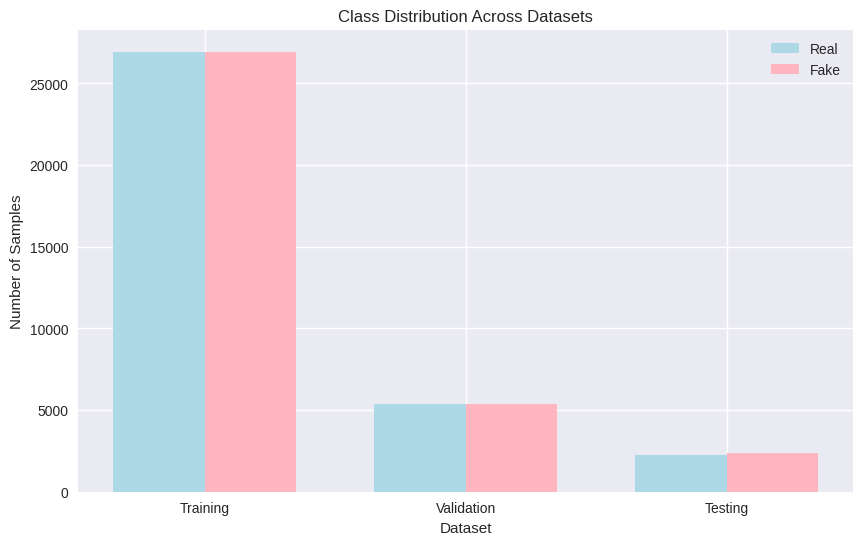

In [24]:
#-------------------
# Create bar plot
#-------------------
plt.figure(figsize=(10, 6))

x = range(len(datasets))
width = 0.35

plt.bar([i - width/2 for i in x], real_counts, width, label='Real', color='lightblue')
plt.bar([i + width/2 for i in x], fake_counts, width, label='Fake', color='lightpink')

plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Across Datasets')
plt.xticks(x, datasets)
plt.legend()
plt.show()

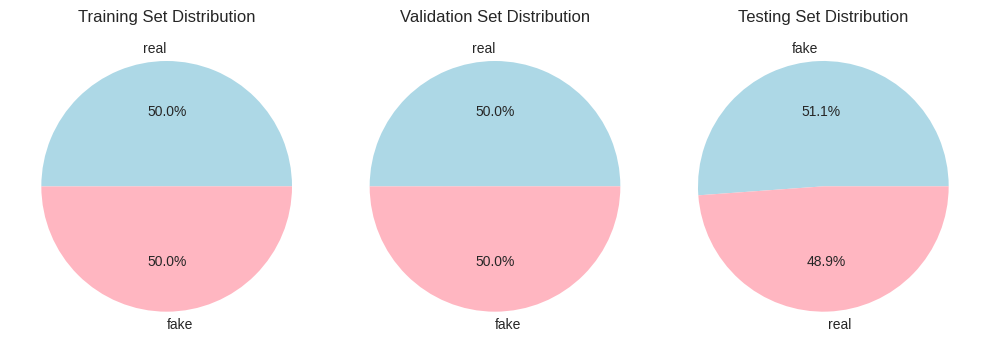

In [16]:
#-------------------
# Create pie charts
#-------------------
plt.figure(figsize=(10, 5))

# Training set pie chart
plt.subplot(131)
train_counts = train_df['label'].value_counts()
plt.pie(train_counts, labels=train_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Training Set Distribution')

# Validation set pie chart
plt.subplot(132)
val_counts = val_df['label'].value_counts()
plt.pie(val_counts, labels=val_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Validation Set Distribution')

# Testing set pie chart
plt.subplot(133)
test_counts = test_df['label'].value_counts()
plt.pie(test_counts, labels=test_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Testing Set Distribution')
plt.tight_layout()
plt.show()

In [17]:
#-------------------
# Print overall statistics
#-------------------
total_samples = len(train_df) + len(val_df) + len(test_df)
print("\nOverall Dataset Statistics:")
print("-" * 30)
print(f"Total number of samples: {total_samples}")
print(f"Training set: {len(train_df)} samples ({len(train_df)/total_samples*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/total_samples*100:.1f}%)")
print(f"Testing set: {len(test_df)} samples ({len(test_df)/total_samples*100:.1f}%)")


Overall Dataset Statistics:
------------------------------
Total number of samples: 69300
Training set: 53868 samples (77.7%)
Validation set: 10798 samples (15.6%)
Testing set: 4634 samples (6.7%)


# Analysis 📊 

In [6]:
# Paths for the dataset
DATASET_BASE_PATH = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm"
TRAINING_PATH = os.path.join(DATASET_BASE_PATH, "training")
VALIDATION_PATH = os.path.join(DATASET_BASE_PATH, "validation")
TESTING_PATH = os.path.join(DATASET_BASE_PATH, "testing")

# Load the dataset
train_df = load_audio_files(TRAINING_PATH)
validation_df = load_audio_files(VALIDATION_PATH)
test_df = load_audio_files(TESTING_PATH)

# Combine all dataframes for overall analysis
all_data = pd.concat([train_df, validation_df, test_df], ignore_index=True)


### Loudness Ratio

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


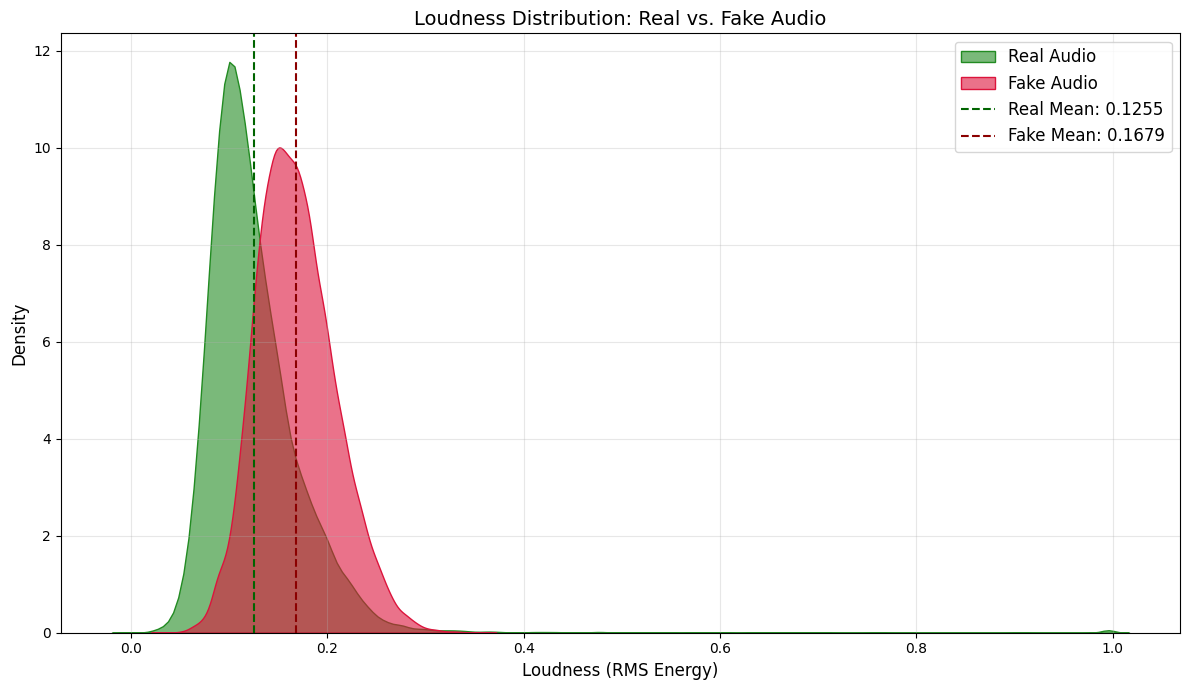

In [1]:
# Function to extract loudness (RMS Energy)
def extract_loudness(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return np.mean(librosa.feature.rms(y=y))

# Extract loudness for all audio files
all_data["loudness"] = all_data["file_path"].apply(extract_loudness)


# 3. KDE (Kernel Density Estimation) Plot with improved visibility
plt.figure(figsize=(12, 7))

# Calculate means for vertical lines
real_mean = all_data[all_data['label'] == 'real']['loudness'].mean()
fake_mean = all_data[all_data['label'] == 'fake']['loudness'].mean()

# Create KDE plot with more distinct colors
sns.kdeplot(
    data=all_data[all_data['label'] == 'real'], 
    x="loudness", 
    fill=True, 
    color="forestgreen", 
    alpha=0.6,
    label="Real Audio"
)

sns.kdeplot(
    data=all_data[all_data['label'] == 'fake'], 
    x="loudness", 
    fill=True, 
    color="crimson", 
    alpha=0.6,
    label="Fake Audio"
)

# Add vertical lines for means
plt.axvline(x=real_mean, color='darkgreen', linestyle='--', label=f'Real Mean: {real_mean:.4f}')
plt.axvline(x=fake_mean, color='darkred', linestyle='--', label=f'Fake Mean: {fake_mean:.4f}')

plt.title("Loudness Distribution: Real vs. Fake Audio", fontsize=14)
plt.xlabel("Loudness (RMS Energy)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Silence Ratio

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


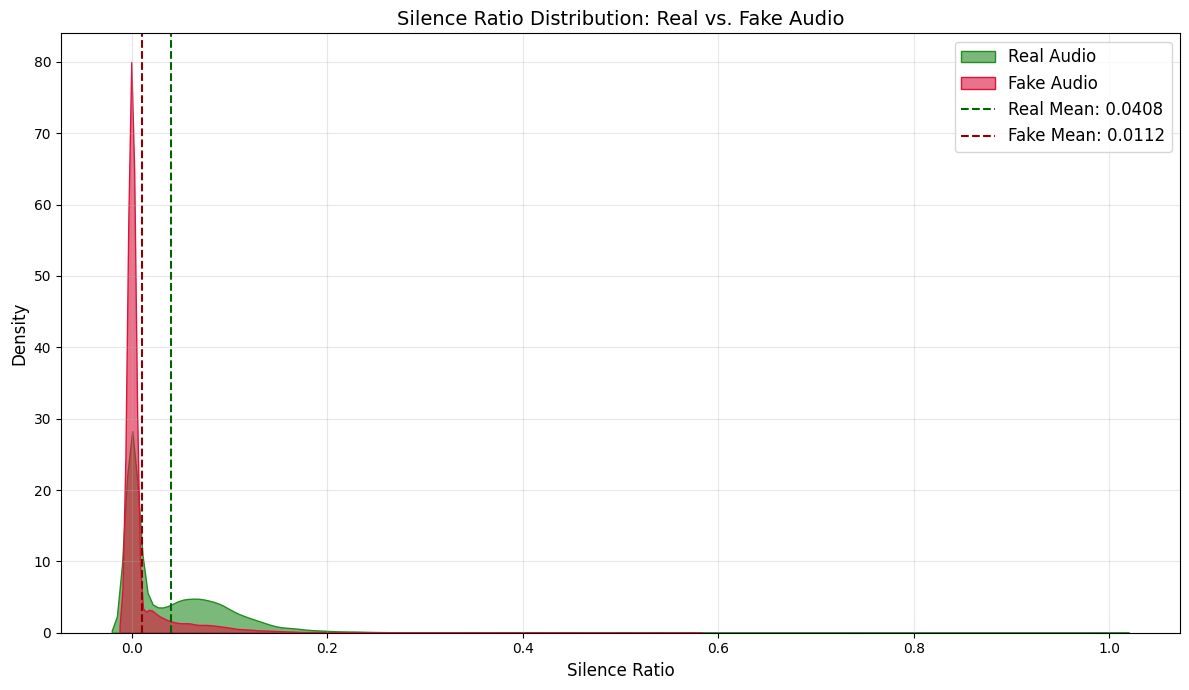

In [5]:
# Function to extract silence ratio
def extract_silence(file_path, threshold=0.01):
    y, sr = librosa.load(file_path, sr=None)
    
    # Calculate RMS energy for short windows
    hop_length = 512
    rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
    
    # Calculate silence ratio (proportion of frames below threshold)
    silence_ratio = np.mean(rms < threshold)
    
    return silence_ratio

# Extract silence ratio for all audio files
all_data["silence_ratio"] = all_data["file_path"].apply(extract_silence)

# 3. KDE (Kernel Density Estimation) Plot with improved visibility
plt.figure(figsize=(12, 7))

# Calculate means for vertical lines
real_mean = all_data[all_data['label'] == 'real']['silence_ratio'].mean()
fake_mean = all_data[all_data['label'] == 'fake']['silence_ratio'].mean()

# Create KDE plot with more distinct colors
sns.kdeplot(
    data=all_data[all_data['label'] == 'real'], 
    x="silence_ratio", 
    fill=True, 
    color="forestgreen", 
    alpha=0.6,
    label="Real Audio"
)
sns.kdeplot(
    data=all_data[all_data['label'] == 'fake'], 
    x="silence_ratio", 
    fill=True, 
    color="crimson", 
    alpha=0.6,
    label="Fake Audio"
)

# Add vertical lines for means
plt.axvline(x=real_mean, color='darkgreen', linestyle='--', label=f'Real Mean: {real_mean:.4f}')
plt.axvline(x=fake_mean, color='darkred', linestyle='--', label=f'Fake Mean: {fake_mean:.4f}')

plt.title("Silence Ratio Distribution: Real vs. Fake Audio", fontsize=14)
plt.xlabel("Silence Ratio", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

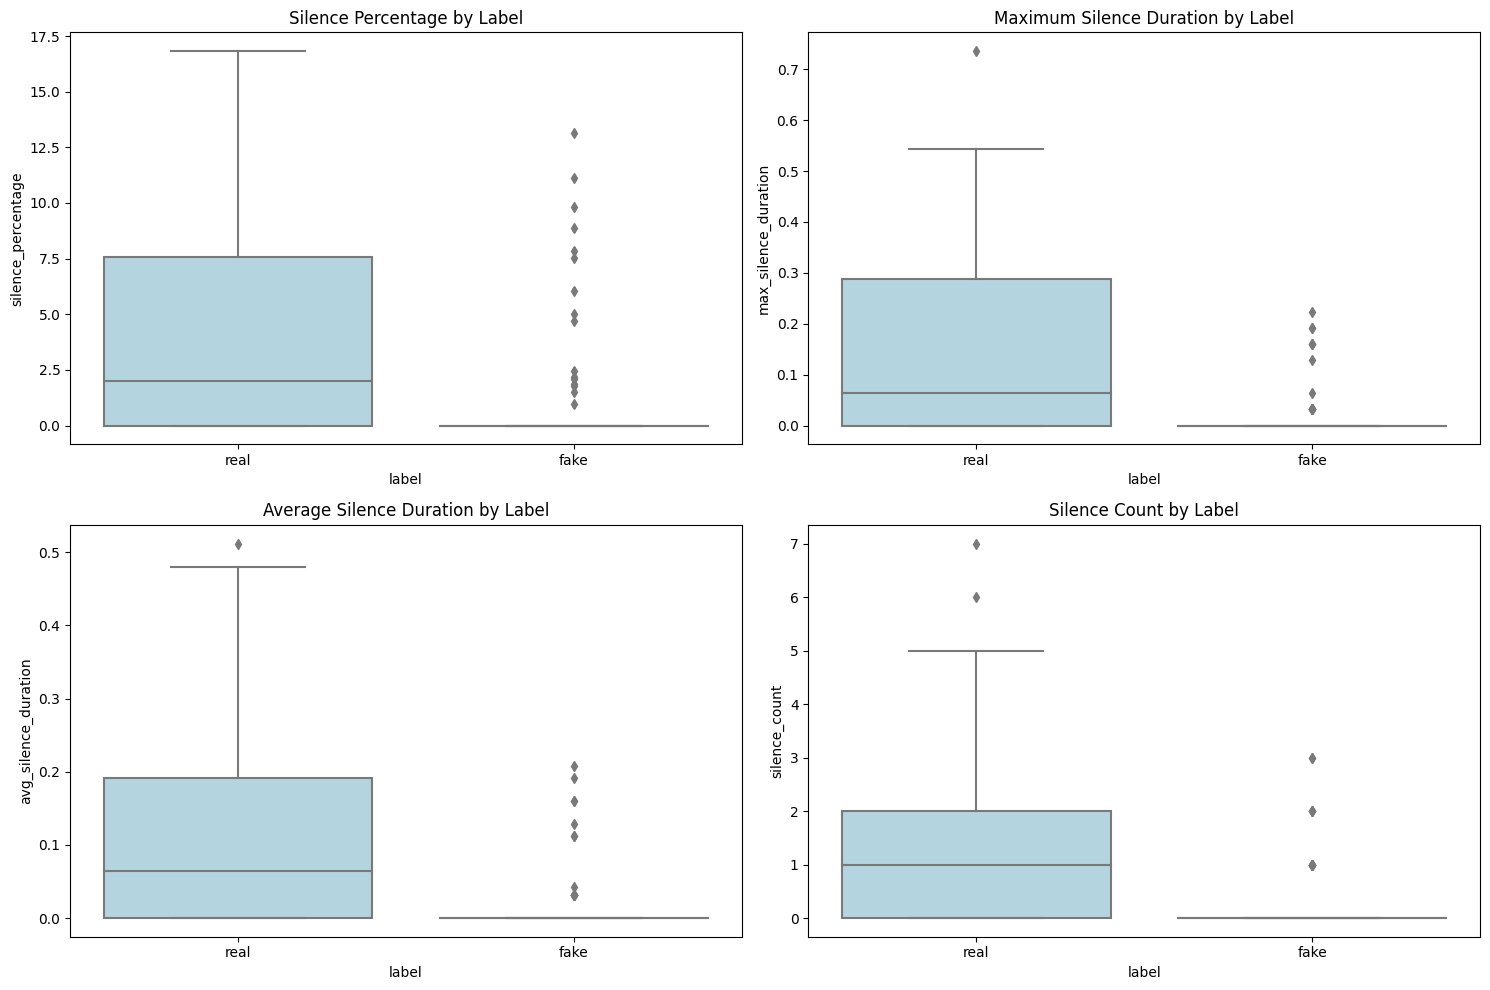

In [8]:
def analyze_silence(file_paths, labels):
    silence_stats = []
    
    for file_path, label in zip(file_paths, labels):
        y, sr = librosa.load(file_path, sr=None)
        
        # Calculate energy
        energy = librosa.feature.rms(y=y)[0]
        
        # Define silence threshold 
        threshold = 0.01
        
        # Calculate silence frames
        silence_frames = np.where(energy < threshold)[0]
        silence_percentage = len(silence_frames) / len(energy) * 100
        
        # Calculate silence run lengths
        silence_runs = []
        if len(silence_frames) > 0:
            # Find consecutive silence frames
            silence_runs = np.split(silence_frames, np.where(np.diff(silence_frames) != 1)[0] + 1)
            
        # Convert frame counts to seconds
        silence_durations = [len(run) * librosa.frames_to_time(1, sr=sr) for run in silence_runs]
        
        silence_stats.append({
            'file_path': file_path,
            'label': label,
            'silence_percentage': silence_percentage,
            'max_silence_duration': max(silence_durations) if silence_durations else 0,
            'avg_silence_duration': np.mean(silence_durations) if silence_durations else 0,
            'silence_count': len(silence_runs)
        })
    
    return pd.DataFrame(silence_stats)

# Analyze silence in a larger sample
real_sample = all_data[all_data['label'] == 'real'].sample(min(100, len(all_data[all_data['label'] == 'real'])))['file_path'].tolist()
fake_sample = all_data[all_data['label'] == 'fake'].sample(min(100, len(all_data[all_data['label'] == 'fake'])))['file_path'].tolist()
sample_files_large = real_sample + fake_sample
sample_labels_large = ['real']*len(real_sample) + ['fake']*len(fake_sample)
silence_df = analyze_silence(sample_files_large, sample_labels_large)

# Visualize silence statistics with custom colors
plt.figure(figsize=(15, 10))

# Set custom color palette with light blue and pink
custom_palette = ["lightblue", "pink"]

plt.subplot(2, 2, 1)
sns.boxplot(data=silence_df, x='label', y='silence_percentage', palette=custom_palette)
plt.title('Silence Percentage by Label')

plt.subplot(2, 2, 2)
sns.boxplot(data=silence_df, x='label', y='max_silence_duration', palette=custom_palette)
plt.title('Maximum Silence Duration by Label')

plt.subplot(2, 2, 3)
sns.boxplot(data=silence_df, x='label', y='avg_silence_duration', palette=custom_palette)
plt.title('Average Silence Duration by Label')

plt.subplot(2, 2, 4)
sns.boxplot(data=silence_df, x='label', y='silence_count', palette=custom_palette)
plt.title('Silence Count by Label')

plt.tight_layout()
plt.show()

### Harmonic Ratio

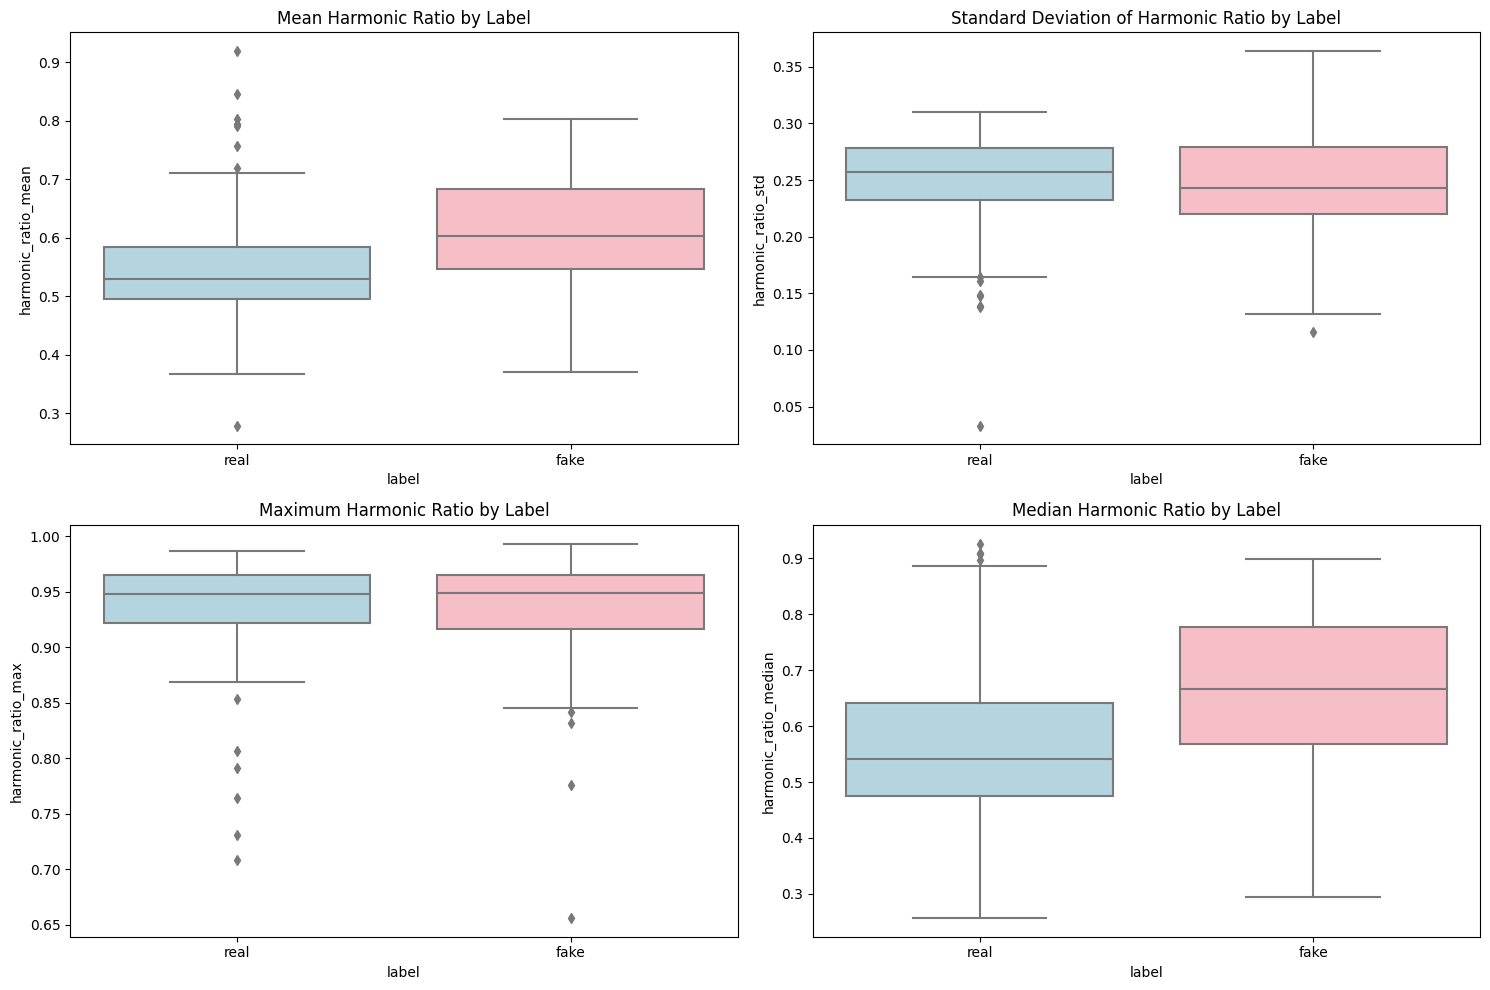

In [5]:
def analyze_harmonic_ratio(file_paths, labels):
    harmonic_stats = []
    
    for file_path, label in zip(file_paths, labels):
        y, sr = librosa.load(file_path, sr=None)
        
        # Calculate harmonic ratio using librosa's harmonic function
        harmonic_ratio = []
        
        # Process in short frames to capture variations
        frame_length = 2048
        hop_length = 512
        
        # Split into frames and calculate harmonic ratio for each frame
        for i in range(0, len(y) - frame_length, hop_length):
            frame = y[i:i + frame_length]
            
            # Calculate harmonic and percussive components
            y_harmonic, y_percussive = librosa.effects.hpss(frame)
            
            # Calculate energy of components
            harmonic_energy = np.sum(y_harmonic**2)
            total_energy = np.sum(frame**2)
            
            # Avoid division by zero
            if total_energy > 0:
                ratio = harmonic_energy / total_energy
            else:
                ratio = 0
                
            harmonic_ratio.append(ratio)
        
        harmonic_ratio = np.array(harmonic_ratio)
        
        harmonic_stats.append({
            'file_path': file_path,
            'label': label,
            'harmonic_ratio_mean': np.mean(harmonic_ratio),
            'harmonic_ratio_std': np.std(harmonic_ratio),
            'harmonic_ratio_min': np.min(harmonic_ratio),
            'harmonic_ratio_max': np.max(harmonic_ratio),
            'harmonic_ratio_median': np.median(harmonic_ratio)
        })
    
    return pd.DataFrame(harmonic_stats)

# Analyze harmonic ratio in a larger sample
real_sample = all_data[all_data['label'] == 'real'].sample(min(100, len(all_data[all_data['label'] == 'real'])))['file_path'].tolist()
fake_sample = all_data[all_data['label'] == 'fake'].sample(min(100, len(all_data[all_data['label'] == 'fake'])))['file_path'].tolist()
sample_files_large = real_sample + fake_sample
sample_labels_large = ['real']*len(real_sample) + ['fake']*len(fake_sample)

# Run analysis
harmonic_df = analyze_harmonic_ratio(sample_files_large, sample_labels_large)

# Visualize harmonic ratio statistics
plt.figure(figsize=(15, 10))

custom_palette = ["lightblue", "lightpink"]

plt.subplot(2, 2, 1)
sns.boxplot(data=harmonic_df, x='label', y='harmonic_ratio_mean', palette=custom_palette)
plt.title('Mean Harmonic Ratio by Label')

plt.subplot(2, 2, 2)
sns.boxplot(data=harmonic_df, x='label', y='harmonic_ratio_std', palette=custom_palette)
plt.title('Standard Deviation of Harmonic Ratio by Label')

plt.subplot(2, 2, 3)
sns.boxplot(data=harmonic_df, x='label', y='harmonic_ratio_max', palette=custom_palette)
plt.title('Maximum Harmonic Ratio by Label')

plt.subplot(2, 2, 4)
sns.boxplot(data=harmonic_df, x='label', y='harmonic_ratio_median', palette=custom_palette)
plt.title('Median Harmonic Ratio by Label')

plt.tight_layout()
plt.show()

### Spectral Flatness (Noise)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(


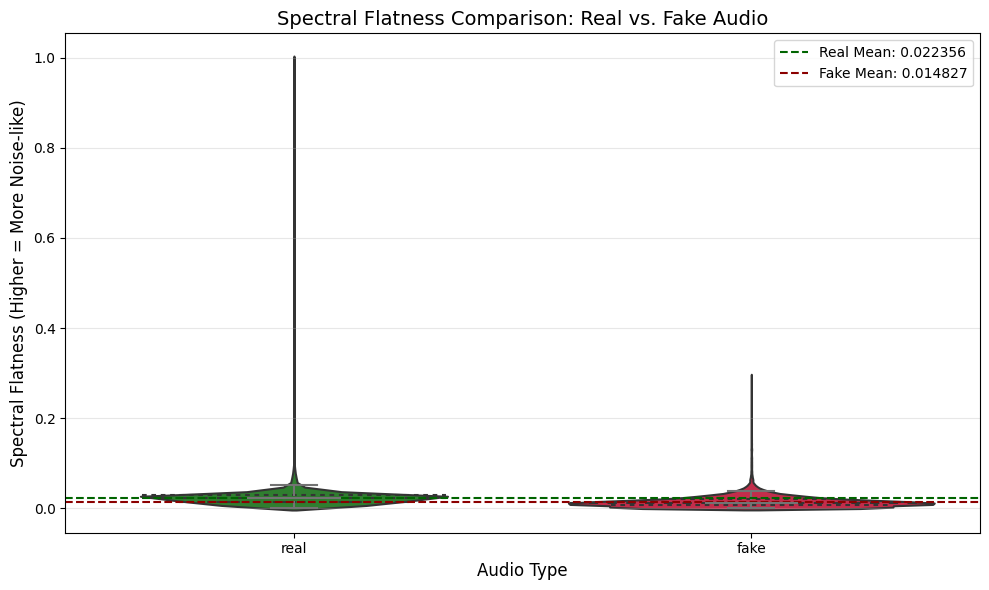

In [2]:
# Function to extract spectral flatness
def extract_spectral_flatness(file_path):
    y, sr = librosa.load(file_path, sr=None)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    return np.mean(spectral_flatness)

# Extract spectral flatness for all audio files
all_data["spectral_flatness"] = all_data["file_path"].apply(extract_spectral_flatness)

# Visualize spectral flatness comparison with improved plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="label", y="spectral_flatness", data=all_data, 
               palette={"real": "forestgreen", "fake": "crimson"}, 
               inner="quartile")

# Add boxplot inside violin plot for better visibility of distribution
sns.boxplot(x="label", y="spectral_flatness", data=all_data, 
            width=0.2, palette={"real": "lightgreen", "fake": "lightpink"}, 
            showfliers=False)

# Calculate and display means
real_mean = all_data[all_data['label'] == 'real']['spectral_flatness'].mean()
fake_mean = all_data[all_data['label'] == 'fake']['spectral_flatness'].mean()

plt.axhline(y=real_mean, color='darkgreen', linestyle='--', 
            label=f'Real Mean: {real_mean:.6f}')
plt.axhline(y=fake_mean, color='darkred', linestyle='--', 
            label=f'Fake Mean: {fake_mean:.6f}')

plt.title("Spectral Flatness Comparison: Real vs. Fake Audio", fontsize=14)
plt.xlabel("Audio Type", fontsize=12)
plt.ylabel("Spectral Flatness (Higher = More Noise-like)", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Brightness

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated 

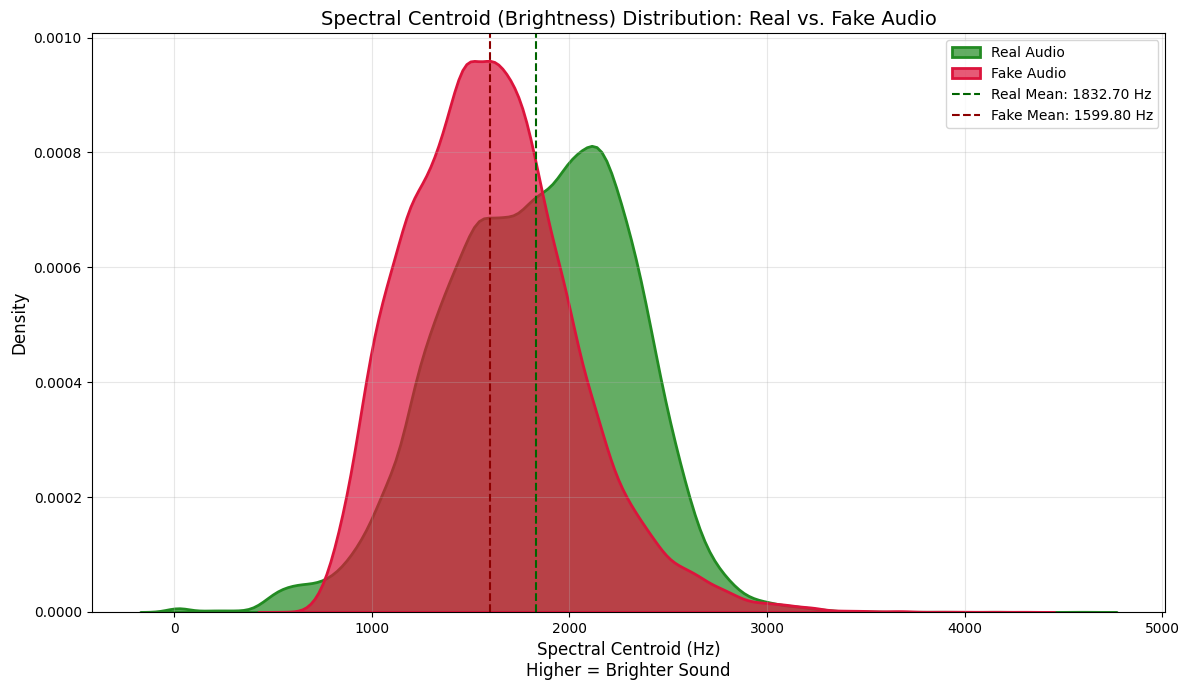

In [3]:
# Function to extract spectral centroid
def extract_spectral_centroid(file_path):
    y, sr = librosa.load(file_path, sr=None)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    return np.mean(spectral_centroid)

# Extract spectral centroid for all audio files
all_data["spectral_centroid"] = all_data["file_path"].apply(extract_spectral_centroid)

# Create an enhanced KDE plot
plt.figure(figsize=(12, 7))

# KDE plot with customized appearance
sns.kdeplot(
    data=all_data[all_data['label'] == 'real'],
    x="spectral_centroid",
    fill=True,
    color="forestgreen",
    alpha=0.7,
    linewidth=2,
    label="Real Audio"
)

sns.kdeplot(
    data=all_data[all_data['label'] == 'fake'],
    x="spectral_centroid",
    fill=True,
    color="crimson",
    alpha=0.7,
    linewidth=2,
    label="Fake Audio"
)

# Calculate means for vertical lines
real_mean = all_data[all_data['label'] == 'real']['spectral_centroid'].mean()
fake_mean = all_data[all_data['label'] == 'fake']['spectral_centroid'].mean()

# Add mean lines
plt.axvline(x=real_mean, color='darkgreen', linestyle='--', 
            label=f'Real Mean: {real_mean:.2f} Hz')
plt.axvline(x=fake_mean, color='darkred', linestyle='--', 
            label=f'Fake Mean: {fake_mean:.2f} Hz')

plt.title("Spectral Centroid (Brightness) Distribution: Real vs. Fake Audio", fontsize=14)
plt.xlabel("Spectral Centroid (Hz)\nHigher = Brighter Sound", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Pitch Analysis

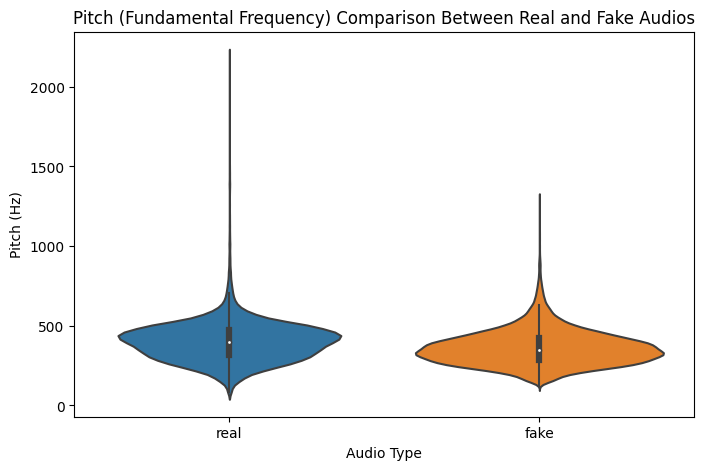

In [10]:
# Function to extract pitch (f0)
def extract_pitch(file_path):
    y, sr = librosa.load(file_path, sr=None)
    f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    return np.mean(f0)

# Extract pitch for all audio files
all_data["pitch"] = all_data["file_path"].apply(extract_pitch)

# Visualize pitch comparison
plt.figure(figsize=(8, 5))
sns.violinplot(x="label", y="pitch", data=all_data)
plt.title("Pitch (Fundamental Frequency) Comparison Between Real and Fake Audios")
plt.xlabel("Audio Type")
plt.ylabel("Pitch (Hz)")
plt.show()

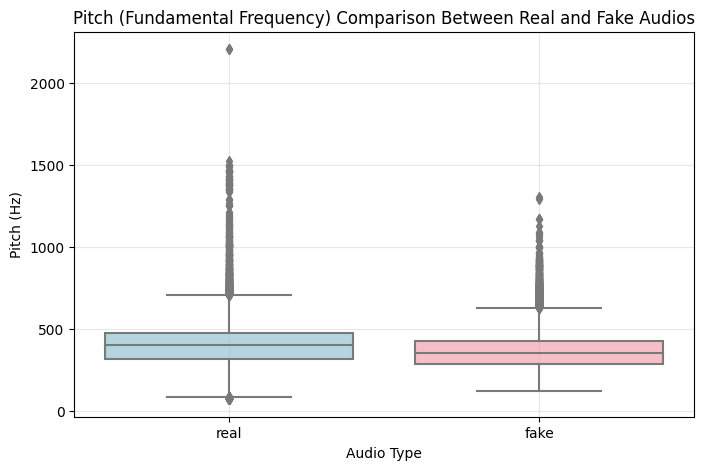

In [8]:
# Function to extract pitch (f0)
def extract_pitch(file_path):
    y, sr = librosa.load(file_path, sr=None)
    f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    return np.mean(f0)

# Extract pitch for all audio files
all_data["pitch"] = all_data["file_path"].apply(extract_pitch)

# Visualize pitch comparison with boxplot using light blue and light pink
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="label", 
    y="pitch", 
    data=all_data,
    palette={"real": "lightblue", "fake": "lightpink"}
)

plt.title("Pitch (Fundamental Frequency) Comparison Between Real and Fake Audios")
plt.xlabel("Audio Type")
plt.ylabel("Pitch (Hz)")
plt.grid(alpha=0.3)
plt.show()

### Chroma Features

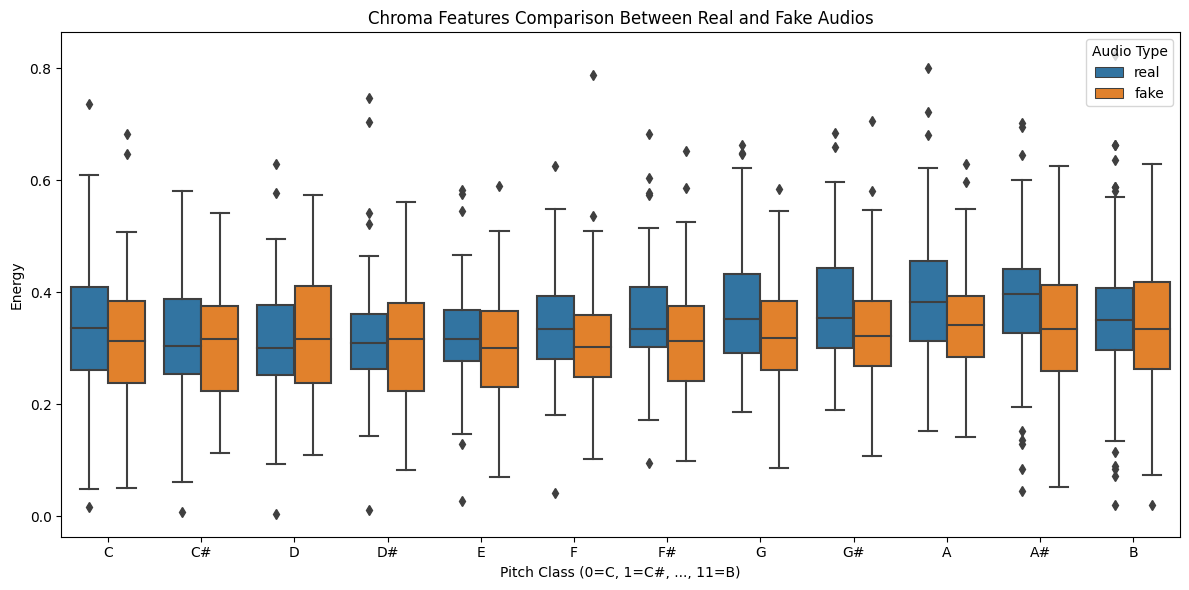

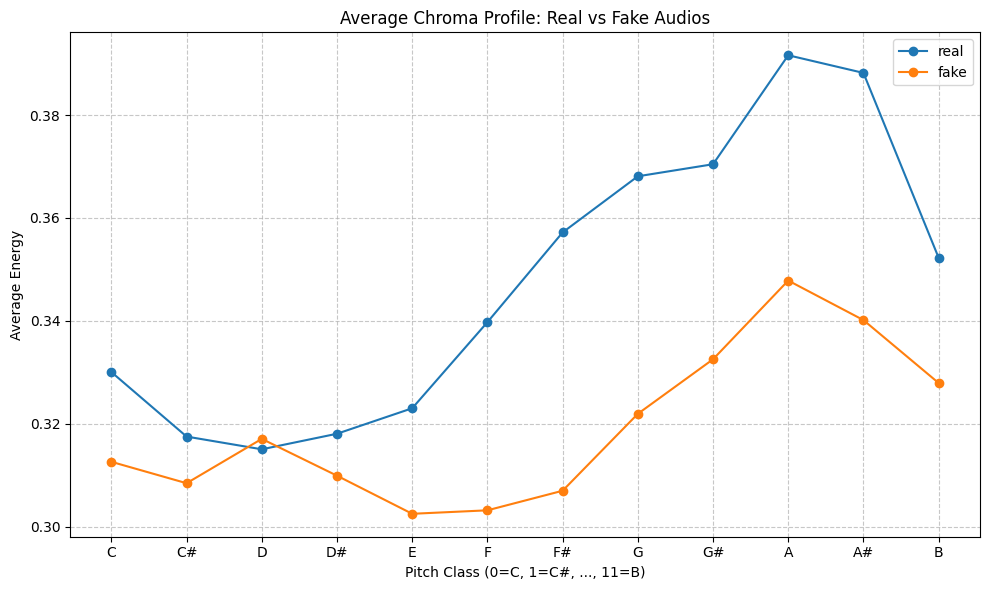

In [13]:
# Function to extract chroma features
def extract_chroma(file_path):
    y, sr = librosa.load(file_path, sr=None)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return np.mean(chroma, axis=1)  # Average across time

# Extract chroma for a sample of files (this could be computationally intensive for all files)
# Using a smaller sample size for demonstration
sample_size = min(200, len(all_data))
sample_data = all_data.sample(sample_size, random_state=42)
sample_data["chroma"] = sample_data["file_path"].apply(extract_chroma)

# Create a dataframe for visualization
chroma_df = pd.DataFrame()
for i, row in sample_data.iterrows():
    temp_df = pd.DataFrame({
        'pitch_class': range(12),
        'energy': row['chroma'],
        'label': row['label']
    })
    chroma_df = pd.concat([chroma_df, temp_df])

# Visualize chroma comparison
plt.figure(figsize=(12, 6))
sns.boxplot(x="pitch_class", y="energy", hue="label", data=chroma_df)
plt.title("Chroma Features Comparison Between Real and Fake Audios")
plt.xlabel("Pitch Class (0=C, 1=C#, ..., 11=B)")
plt.ylabel("Energy")
plt.legend(title="Audio Type")
plt.xticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.tight_layout()
plt.show()

# Alternative visualization: average chroma profiles per class
plt.figure(figsize=(10, 6))
for label in ["real", "fake"]:
    class_data = chroma_df[chroma_df["label"] == label]
    mean_values = class_data.groupby("pitch_class")["energy"].mean()
    plt.plot(range(12), mean_values, marker='o', label=label)

plt.title("Average Chroma Profile: Real vs Fake Audios")
plt.xlabel("Pitch Class (0=C, 1=C#, ..., 11=B)")
plt.ylabel("Average Energy")
plt.xticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Spectral Centroid and Bandwidth

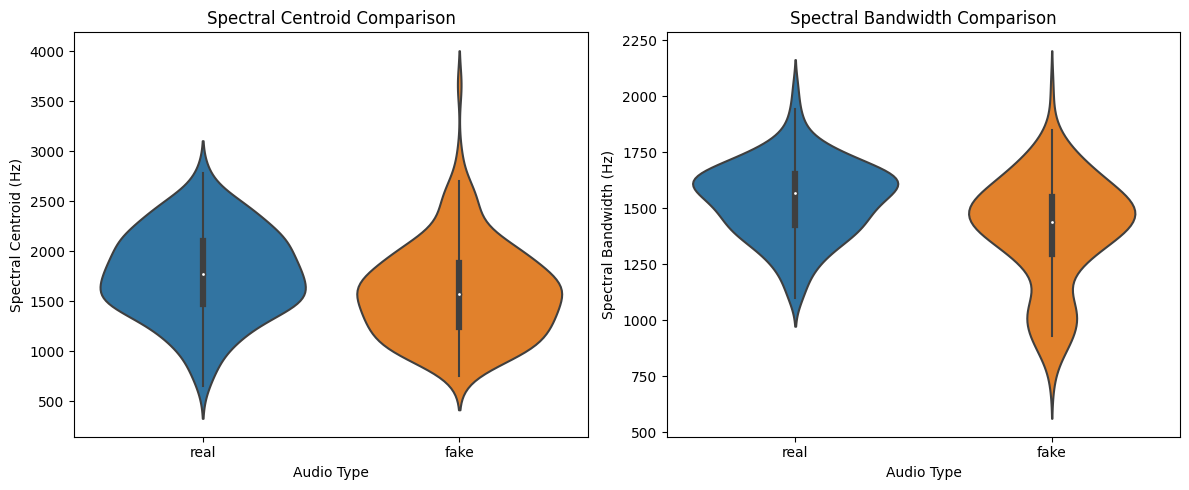

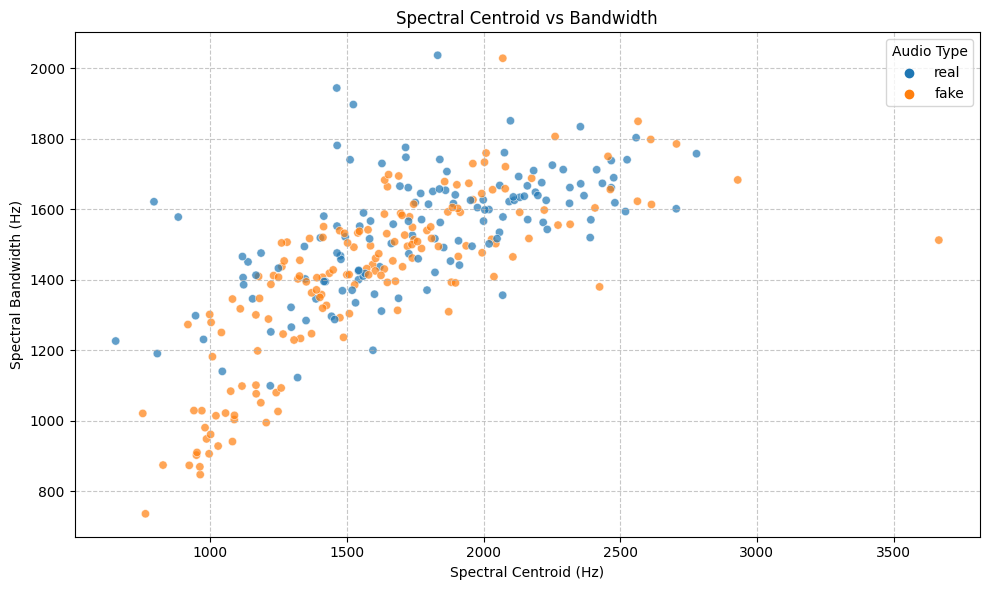

Statistical Summary by Audio Type:
      centroid_mean                                                    \
              count         mean         std         min          25%   
label                                                                   
fake          163.0  1588.932928  470.572721  753.466260  1244.909907   
real          137.0  1774.238324  436.250603  654.365061  1476.629964   

                                             centroid_std               ...  \
               50%          75%          max        count         mean  ...   
label                                                                   ...   
fake   1572.707624  1877.600440  3665.734331        163.0   936.235201  ...   
real   1770.235216  2098.536495  2779.257495        137.0  1097.700587  ...   

      bandwidth_mean              bandwidth_std                          \
                 75%          max         count        mean         std   
label                                                

In [14]:
# Function to extract spectral centroid and bandwidth
def extract_spectral_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # Calculate spectral centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    
    # Calculate spectral bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    
    return {
        'centroid_mean': np.mean(centroid),
        'centroid_std': np.std(centroid),
        'bandwidth_mean': np.mean(bandwidth),
        'bandwidth_std': np.std(bandwidth)
    }

# Sample size for demonstration (adjust based on computational resources)
sample_size = min(300, len(all_data))
sample_data = all_data.sample(sample_size, random_state=42)

# Extract spectral features for sample data
spectral_features = []
for idx, row in sample_data.iterrows():
    features = extract_spectral_features(row['file_path'])
    features['label'] = row['label']
    spectral_features.append(features)

# Create dataframe with extracted features
spectral_df = pd.DataFrame(spectral_features)

# Visualize Spectral Centroid comparison
plt.figure(figsize=(12, 5))

# Plot 1: Spectral Centroid
plt.subplot(1, 2, 1)
sns.violinplot(x="label", y="centroid_mean", data=spectral_df)
plt.title("Spectral Centroid Comparison")
plt.xlabel("Audio Type")
plt.ylabel("Spectral Centroid (Hz)")

# Plot 2: Spectral Bandwidth
plt.subplot(1, 2, 2)
sns.violinplot(x="label", y="bandwidth_mean", data=spectral_df)
plt.title("Spectral Bandwidth Comparison")
plt.xlabel("Audio Type")
plt.ylabel("Spectral Bandwidth (Hz)")

plt.tight_layout()
plt.show()

# Create a scatter plot to see if there's a correlation between the two features
plt.figure(figsize=(10, 6))
sns.scatterplot(x="centroid_mean", y="bandwidth_mean", hue="label", data=spectral_df, alpha=0.7)
plt.title("Spectral Centroid vs Bandwidth")
plt.xlabel("Spectral Centroid (Hz)")
plt.ylabel("Spectral Bandwidth (Hz)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Audio Type")
plt.tight_layout()
plt.show()

# Statistical summary
print("Statistical Summary by Audio Type:")
print(spectral_df.groupby('label').describe())

### Duration

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


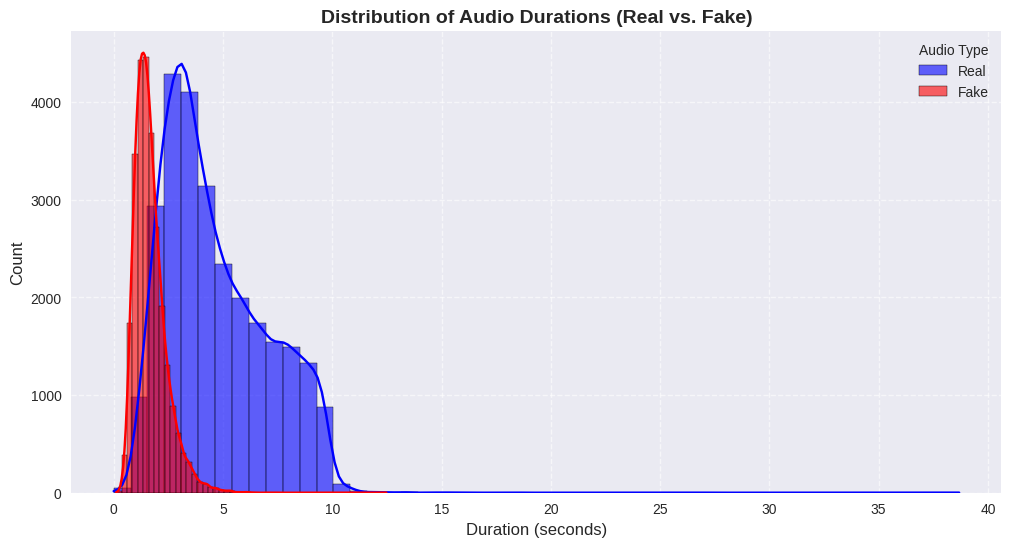

In [47]:
# Function to get the duration of an audio file
def get_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return librosa.get_duration(y=y, sr=sr)

# Compute duration for all datasets
train_df['duration'] = train_df['file_path'].apply(get_duration)
validation_df['duration'] = validation_df['file_path'].apply(get_duration)
test_df['duration'] = test_df['file_path'].apply(get_duration)

# Plot the distribution of durations for real vs. fake audio
plt.figure(figsize=(12, 6), facecolor='white')

sns.histplot(train_df[train_df['label'] == 'real']['duration'], bins=50, kde=True, color='blue', label='Real', alpha=0.6)
sns.histplot(train_df[train_df['label'] == 'fake']['duration'], bins=50, kde=True, color='red', label='Fake', alpha=0.6)

plt.title('Distribution of Audio Durations (Real vs. Fake)', fontsize=14, fontweight='bold')
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Audio Type')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

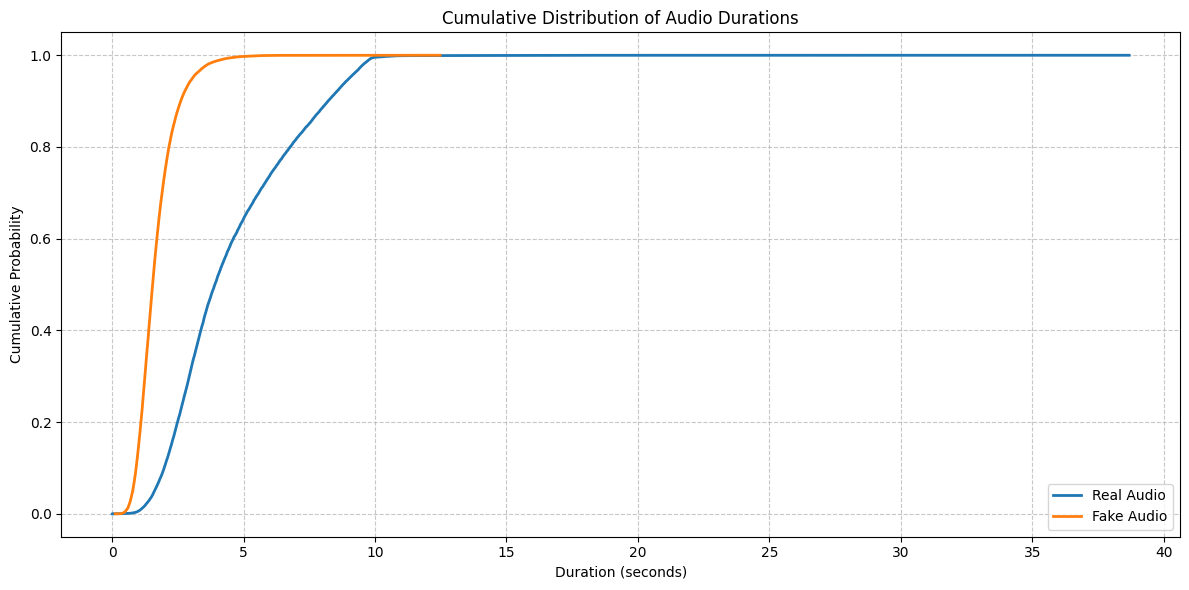

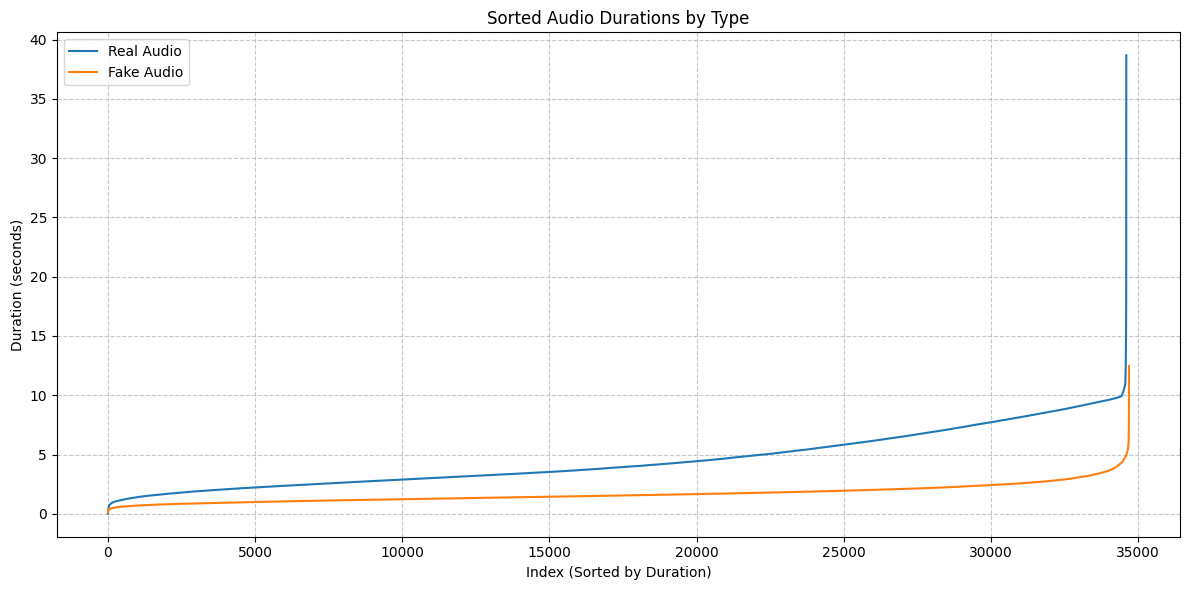

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


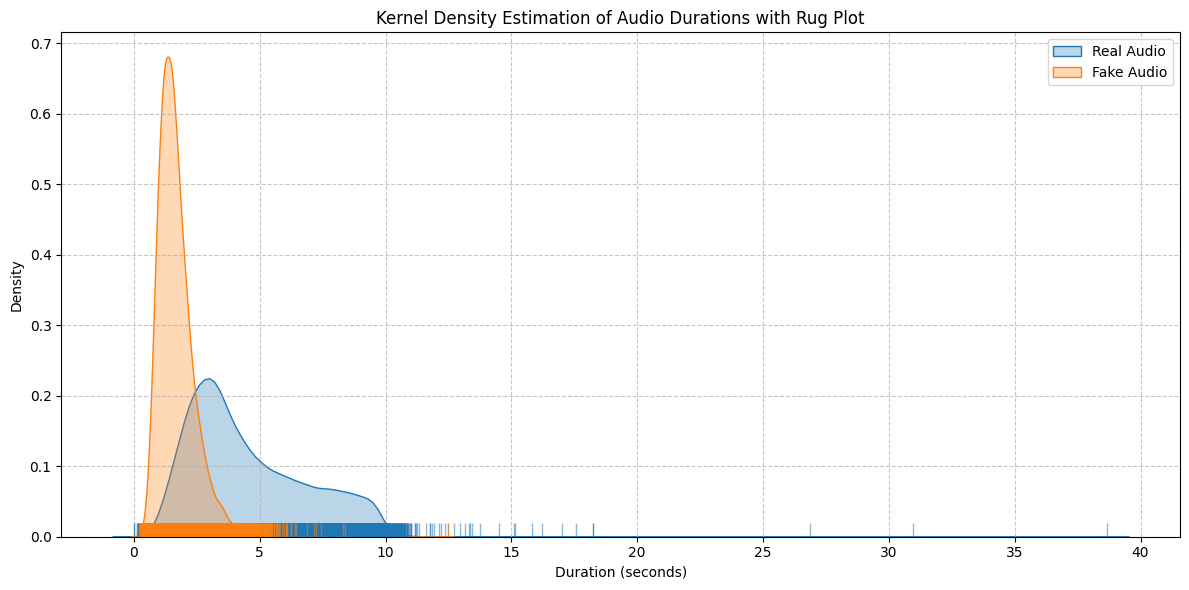

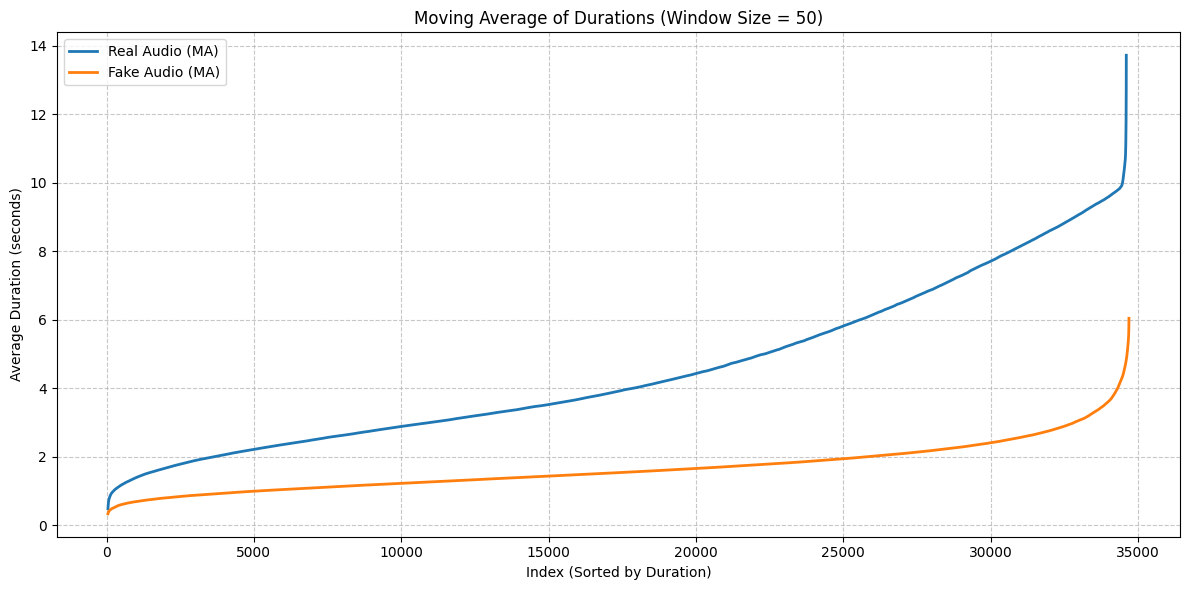

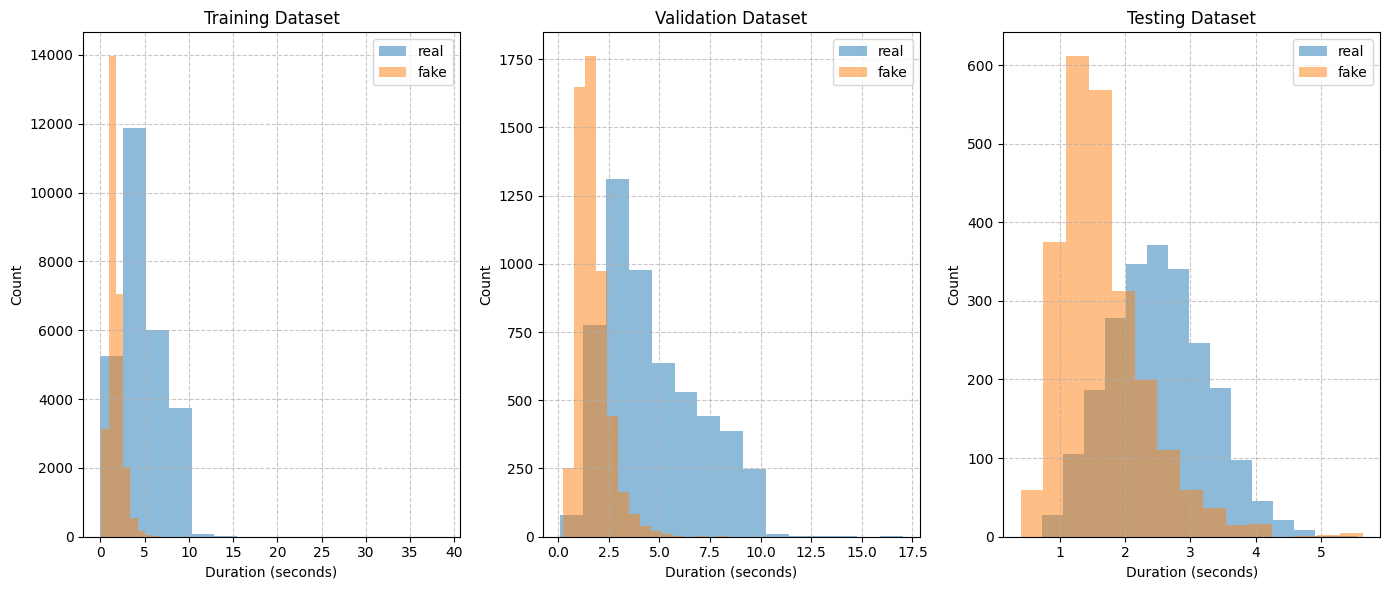

Duration Statistics by Dataset and Audio Type:
                  mean  median   std   min    max
dataset    label                                 
testing    fake   1.66    1.53  0.66  0.40   5.64
           real   2.52    2.49  0.75  0.73   5.55
training   fake   1.68    1.54  0.73  0.12  12.47
           real   4.68    4.12  2.34  0.00  38.68
validation fake   1.69    1.55  0.75  0.23   8.41
           real   4.64    4.04  2.32  0.11  17.02


In [16]:
# Function to extract duration of audio files
def get_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return librosa.get_duration(y=y, sr=sr)

# Extract duration for all audio files
all_data['duration'] = all_data['file_path'].apply(get_duration)

# Add dataset type (train, validation, test)
all_data['dataset'] = ''
all_data.loc[all_data['file_path'].str.contains('/training/'), 'dataset'] = 'training'
all_data.loc[all_data['file_path'].str.contains('/validation/'), 'dataset'] = 'validation'
all_data.loc[all_data['file_path'].str.contains('/testing/'), 'dataset'] = 'testing'

# Sort by duration
all_data = all_data.sort_values('duration')
# Add index for line plot
all_data = all_data.reset_index(drop=True)

# 1. Cumulative Distribution Function (CDF) plot
plt.figure(figsize=(12, 6))
for label in ['real', 'fake']:
    subset = all_data[all_data['label'] == label]
    x = np.sort(subset['duration'])
    y = np.arange(1, len(x) + 1) / len(x)
    plt.plot(x, y, label=f'{label.capitalize()} Audio', linewidth=2)

plt.title('Cumulative Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Cumulative Probability')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Line plot of sorted durations by label
plt.figure(figsize=(12, 6))
for label in ['real', 'fake']:
    subset = all_data[all_data['label'] == label].sort_values('duration').reset_index(drop=True)
    plt.plot(subset.index, subset['duration'], label=f'{label.capitalize()} Audio', linewidth=1.5)

plt.title('Sorted Audio Durations by Type')
plt.xlabel('Index (Sorted by Duration)')
plt.ylabel('Duration (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Kernel Density Estimation (KDE) with rug plot
plt.figure(figsize=(12, 6))
for label in ['real', 'fake']:
    subset = all_data[all_data['label'] == label]
    sns.kdeplot(subset['duration'], label=f'{label.capitalize()} Audio', fill=True, alpha=0.3)
    plt.plot(subset['duration'], np.zeros_like(subset['duration']), '|', ms=20, alpha=0.5)

plt.title('Kernel Density Estimation of Audio Durations with Rug Plot')
plt.xlabel('Duration (seconds)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Moving average plot
plt.figure(figsize=(12, 6))
window_size = 50 

for label in ['real', 'fake']:
    subset = all_data[all_data['label'] == label].sort_values('duration').reset_index(drop=True)
    subset['rolling_avg'] = subset['duration'].rolling(window=window_size).mean()
    plt.plot(subset.index, subset['rolling_avg'], label=f'{label.capitalize()} Audio (MA)', linewidth=2)

plt.title(f'Moving Average of Durations (Window Size = {window_size})')
plt.xlabel('Index (Sorted by Duration)')
plt.ylabel('Average Duration (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# 5. Duration distribution across datasets
plt.figure(figsize=(14, 6))
for i, dataset in enumerate(['training', 'validation', 'testing']):
    plt.subplot(1, 3, i+1)
    dataset_data = all_data[all_data['dataset'] == dataset]
    for label in ['real', 'fake']:
        subset = dataset_data[dataset_data['label'] == label]
        plt.hist(subset['duration'], alpha=0.5, bins=15, label=label)
    
    plt.title(f'{dataset.capitalize()} Dataset')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 6. Statistical summary by label and dataset
duration_stats = all_data.groupby(['dataset', 'label'])['duration'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
print("Duration Statistics by Dataset and Audio Type:")
print(duration_stats)

### Waveform

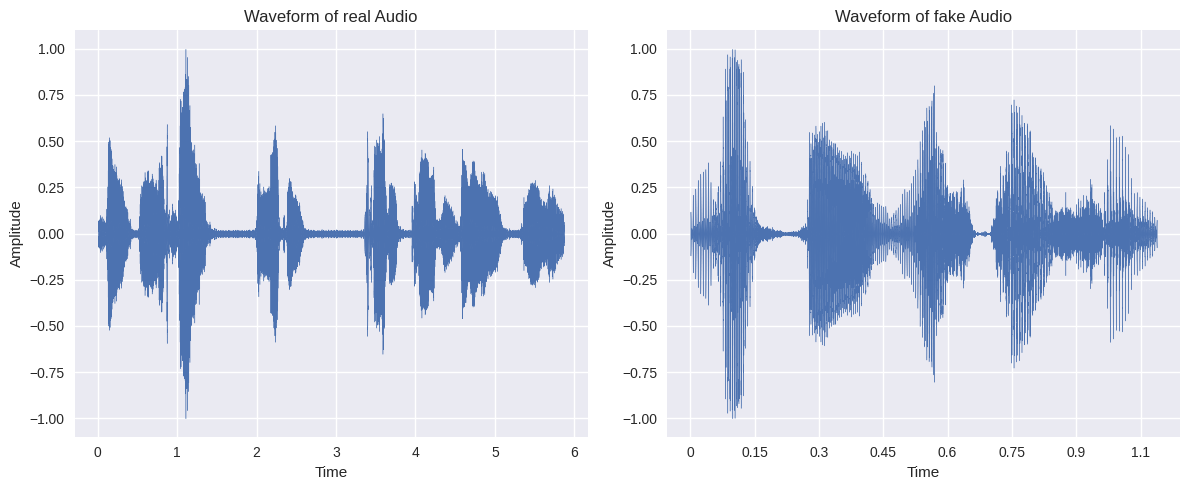

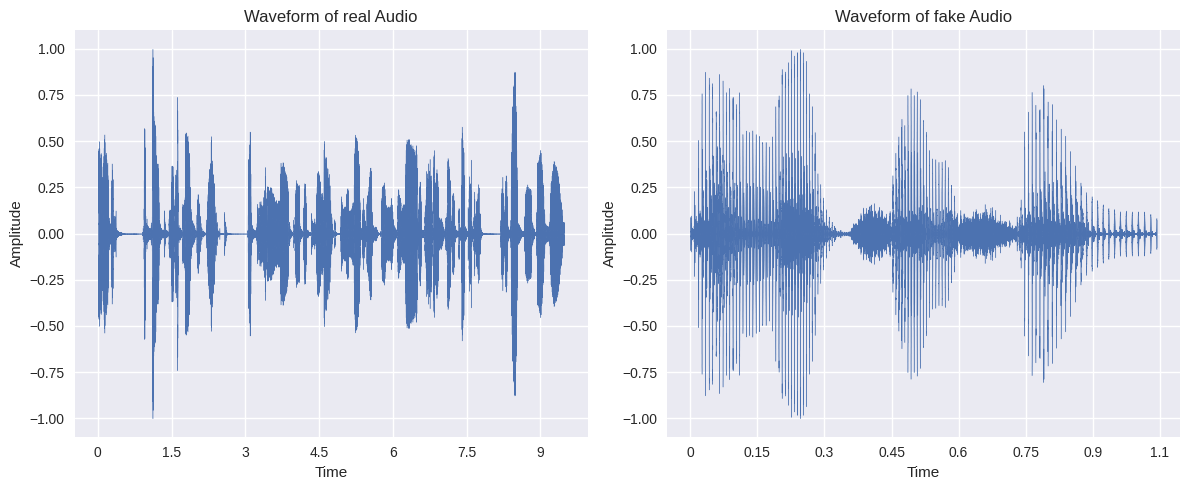

In [27]:
# Function to plot waveforms of real and fake audio side by side
def plot_waveform_comparison(real_file, fake_file, real_label, fake_label):
    y_real, sr_real = librosa.load(real_file, sr=None)
    y_fake, sr_fake = librosa.load(fake_file, sr=None)

    plt.figure(figsize=(12, 5))

    # Plot real audio waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y_real, sr=sr_real)
    plt.title(f'Waveform of {real_label} Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot fake audio waveform
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(y_fake, sr=sr_fake)
    plt.title(f'Waveform of {fake_label} Audio')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Get real and fake audio samples
real_samples = train_df[train_df['label'] == 'real'].head(2)
fake_samples = train_df[train_df['label'] == 'fake'].head(2)

# Plot a few pairs of real and fake audio waveforms
for (real_file, real_label), (fake_file, fake_label) in zip(real_samples[['file_path', 'label']].values, 
                                                             fake_samples[['file_path', 'label']].values):
    plot_waveform_comparison(real_file, fake_file, real_label, fake_label)

### Spectrograms

<ipython-input-46-ee3ef47cf5fa>:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_real = librosa.amplitude_to_db(librosa.stft(y_real), ref=np.max)
<ipython-input-46-ee3ef47cf5fa>:13: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_fake = librosa.amplitude_to_db(librosa.stft(y_fake), ref=np.max)


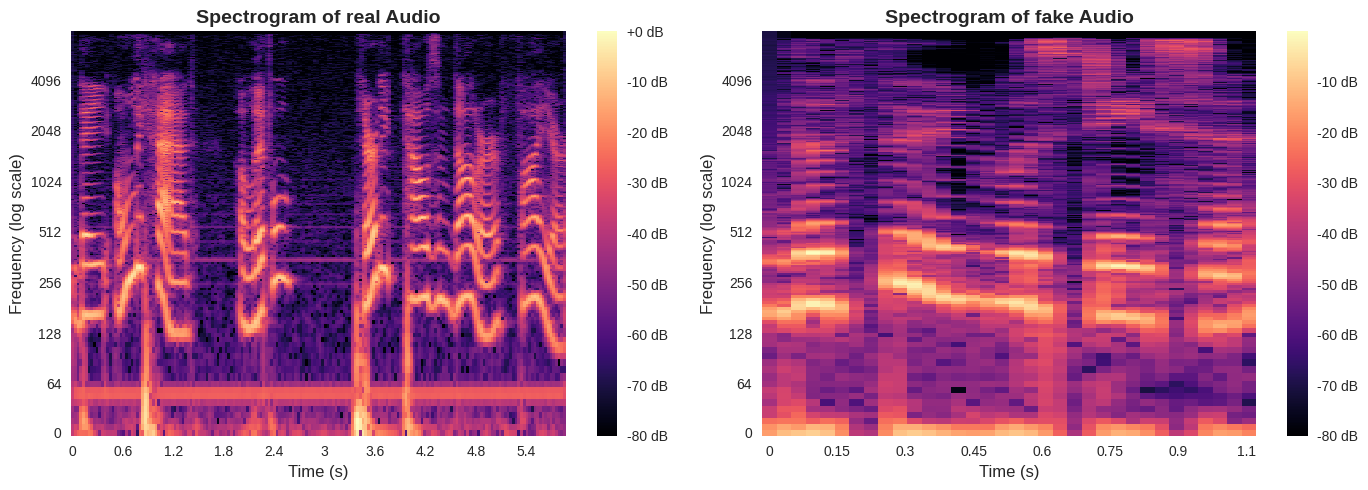

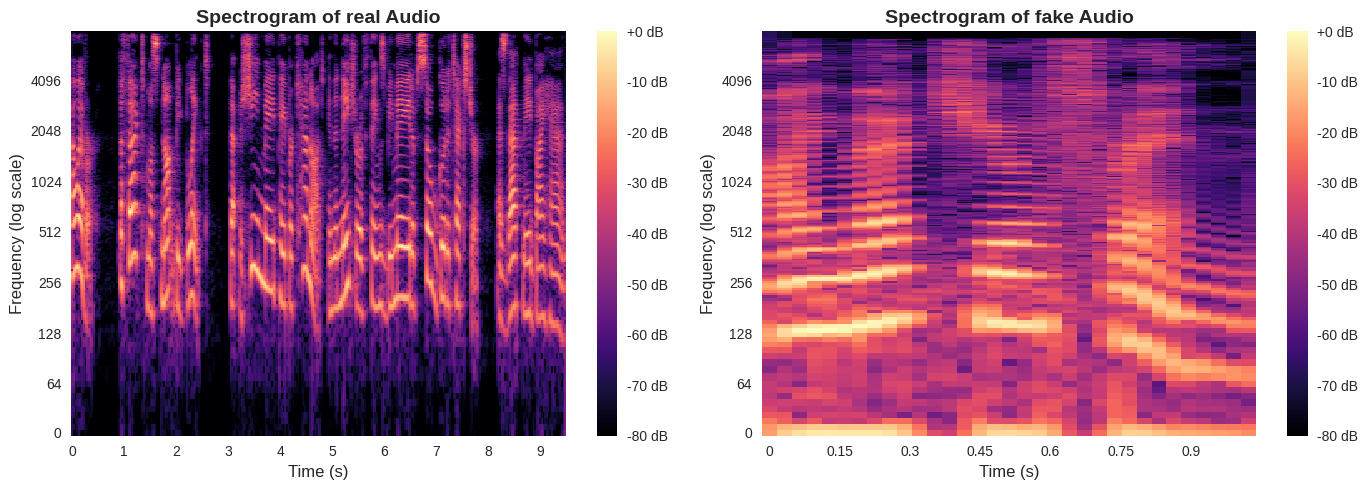

In [46]:
# Function to plot spectrograms of real and fake audio side by side
def plot_spectrogram_comparison(real_file, fake_file, real_label, fake_label):
    y_real, sr_real = librosa.load(real_file, sr=None)
    y_fake, sr_fake = librosa.load(fake_file, sr=None)

    # Compute spectrograms
    D_real = librosa.amplitude_to_db(librosa.stft(y_real), ref=np.max)
    D_fake = librosa.amplitude_to_db(librosa.stft(y_fake), ref=np.max)

    plt.figure(figsize=(14, 5), facecolor='white')

    # Plot real audio spectrogram
    plt.subplot(1, 2, 1)
    librosa.display.specshow(D_real, sr=sr_real, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {real_label} Audio', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (log scale)', fontsize=12)

    # Plot fake audio spectrogram
    plt.subplot(1, 2, 2)
    librosa.display.specshow(D_fake, sr=sr_fake, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {fake_label} Audio', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (log scale)', fontsize=12)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Get real and fake audio samples
real_samples = train_df[train_df['label'] == 'real'].head(2)
fake_samples = train_df[train_df['label'] == 'fake'].head(2)

# Plot a few pairs of real and fake audio spectrograms
for (real_file, real_label), (fake_file, fake_label) in zip(real_samples[['file_path', 'label']].values, 
                                                             fake_samples[['file_path', 'label']].values):
    plot_spectrogram_comparison(real_file, fake_file, real_label, fake_label)

### MFCCs

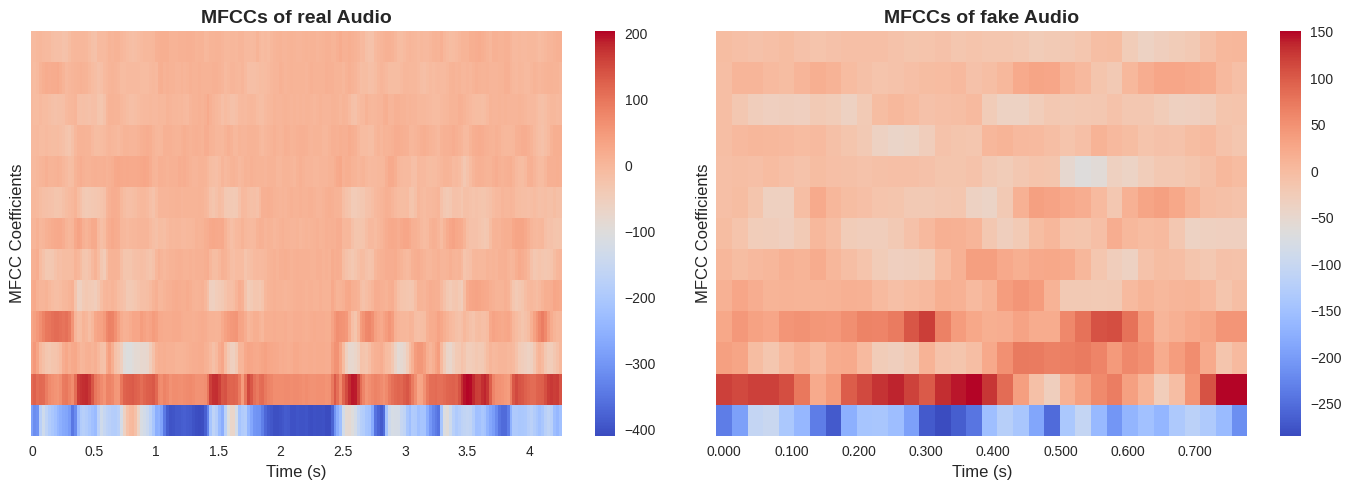

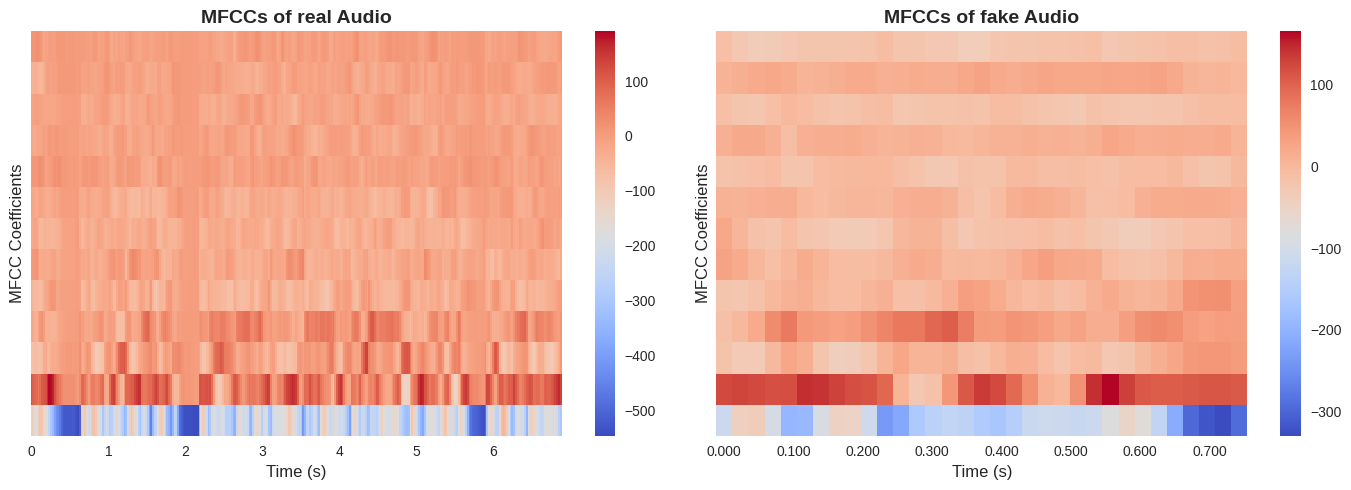

In [45]:
# Function to plot MFCCs of real and fake audio side by side
def plot_mfcc_comparison(real_file, fake_file, real_label, fake_label):
    y_real, sr_real = librosa.load(real_file, sr=None)
    y_fake, sr_fake = librosa.load(fake_file, sr=None)

    # Compute MFCCs
    mfccs_real = librosa.feature.mfcc(y=y_real, sr=sr_real, n_mfcc=13)
    mfccs_fake = librosa.feature.mfcc(y=y_fake, sr=sr_fake, n_mfcc=13)

    plt.figure(figsize=(14, 5), facecolor='white')

    # Plot real audio MFCC
    plt.subplot(1, 2, 1)
    librosa.display.specshow(mfccs_real, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCCs of {real_label} Audio', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('MFCC Coefficients', fontsize=12)

    # Plot fake audio MFCC
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfccs_fake, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCCs of {fake_label} Audio', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('MFCC Coefficients', fontsize=12)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Get real and fake audio samples
real_samples = train_df[train_df['label'] == 'real'].head(2)
fake_samples = train_df[train_df['label'] == 'fake'].head(2)

# Plot a few pairs of real and fake audio MFCCs
for (real_file, real_label), (fake_file, fake_label) in zip(real_samples[['file_path', 'label']].values, 
                                                             fake_samples[['file_path', 'label']].values):
    plot_mfcc_comparison(real_file, fake_file, real_label, fake_label)

# Preprocessing 🔎

In [ ]:
# Extract MFCC and additional features with noise handling
def extract_features(file_path, sr=16000, n_mfcc=40, duration=12):
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr * 0.1:
            print(f"Skipping short file: {file_path}")
            return None
        
        # Simple noise reduction
        # Assuming first 100ms is silence/noise, estimate noise profile
        noise_sample = y[:int(sr * 0.1)]
        if len(noise_sample) > 0:
            noise_mean = np.mean(noise_sample)
            noise_std = np.std(noise_sample)
            # Set a threshold for noise removal (3 standard deviations)
            threshold = noise_mean + 3 * noise_std
            # Apply soft noise gate
            y = np.where(np.abs(y) < threshold, y * 0.1, y)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < 3:
            print(f"Insufficient frames for delta computation in file: {file_path}")
            return None
        
        # Resize MFCC for modeling
        mfcc_resized = librosa.util.fix_length(mfcc, size=224, axis=1)
        if mfcc_resized.shape[1] < 224:
            padding = 224 - mfcc_resized.shape[1]
            mfcc_resized = np.pad(mfcc_resized, ((0, 0), (0, padding)), mode='constant')
        mfcc_img = np.resize(mfcc_resized, (128, 128))
        mfcc_img_3ch = np.stack((mfcc_img, mfcc_img, mfcc_img), axis=-1)
        
        # Apply pretrained models preprocessing
        mfcc_img_3ch = preprocess_input(mfcc_img_3ch)
        
        return mfcc_img_3ch
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None



In [ ]:
# Audio augmentation function
def add_white_noise(audio, noise_level=0.005):
    """Add white noise to audio signal"""
    noise = np.random.normal(0, noise_level, len(audio))
    return audio + noise

In [ ]:
def time_stretch(audio, rate=1.0):
    """Time stretch audio signal without changing pitch"""
    if rate == 1.0:  
        return audio
    return librosa.effects.time_stretch(audio, rate=rate)

In [ ]:
def pitch_shift(audio, sr, n_steps=0):
    """Shift pitch of audio signal"""
    if n_steps == 0:  
        return audio
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)


In [ ]:
def apply_audio_augmentation(y, sr=16000):
    """Apply random audio augmentations"""
    augmented = y.copy()
    
    # Randomly select and apply augmentations
    # 1. Add white noise (50% chance)
    if np.random.random() > 0.5:
        noise_level = np.random.uniform(0.001, 0.01)
        augmented = add_white_noise(augmented, noise_level)
    
    # 2. Time stretch (50% chance)
    if np.random.random() > 0.5:
        stretch_rate = np.random.uniform(0.8, 1.2)
        augmented = time_stretch(augmented, stretch_rate)
    
    # 3. Pitch shift (50% chance)
    if np.random.random() > 0.5:
        n_steps = np.random.randint(-4, 5)
        augmented = pitch_shift(augmented, sr, n_steps)
    
    return augmented

In [ ]:
# Function to test model prediction on a single audio file
def predict_audio_file(model, audio_file_path, label_encoder, sr=16000, n_mfcc=40, duration=12):
    try:
        # Extract features using the same preprocessing as training
        features = extract_features(audio_file_path, sr=sr, n_mfcc=n_mfcc, duration=duration)
        if features is None:
            return "Error: Could not extract features from the audio file", 0.0
        # Reshape features for model input
        features = np.expand_dims(features, axis=0)  
        
        # Get prediction
        prediction = model.predict(features, verbose=0)
        confidence = float(prediction[0][0])
        
        # Convert to binary prediction
        predicted_class = 1 if confidence > 0.5 else 0
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]
        
        # Calculate confidence score (matching deployment logic)
        confidence_score = confidence if predicted_class == 1 else 1.0 - confidence
        
        return predicted_label, confidence_score
        
    except Exception as e:
        return f"Error processing {audio_file_path}: {str(e)}", 0.0



In [ ]:
# Prepare features with online augmentation
def prepare_features(data_path, augment_data=False):
    data = load_audio_files(data_path)
    
    # Process all files
    features_list = []
    valid_indices = []
    
    for idx, file_path in enumerate(data['file_path']):
        features = extract_features(file_path)
        if features is not None:
            features_list.append(features)
            valid_indices.append(idx)
    
    # Filter only valid samples
    valid_data = data.iloc[valid_indices].reset_index(drop=True)
    
    X = np.array(features_list)
    y_raw = valid_data['label'].values
    return X, y_raw, valid_data['file_path'].values

In [ ]:
# Function to create augmented features on-the-fly during training
def augment_mfcc_features(batch_x, batch_y):
    """Apply augmentations directly to MFCC feature representations"""
    augmented_x = batch_x.copy()
    
    for i in range(len(augmented_x)):
        # Random frequency masking (50% chance)
        if np.random.random() > 0.5:
            freq_idx = np.random.randint(0, augmented_x.shape[1] - 10)
            freq_width = np.random.randint(5, 15)
            augmented_x[i, freq_idx:freq_idx+freq_width, :, :] *= np.random.uniform(0.0, 0.6)
        
        # Random time masking (50% chance)
        if np.random.random() > 0.5:
            time_idx = np.random.randint(0, augmented_x.shape[2] - 20)
            time_width = np.random.randint(5, 20)
            augmented_x[i, :, time_idx:time_idx+time_width, :] *= np.random.uniform(0.0, 0.6)
        
        # Random gain adjustment (50% chance)
        if np.random.random() > 0.5:
            gain_factor = np.random.uniform(0.7, 1.3)
            augmented_x[i] = augmented_x[i] * gain_factor
            # Clip to maintain valid range
            augmented_x[i] = np.clip(augmented_x[i], -1.0, 1.0)
    
    return augmented_x, batch_y


In [ ]:
# Custom audio data generator
def audio_data_generator(X, y, batch_size=16, augment=True):
    num_samples = len(X)
    indices = np.arange(num_samples)
    
    while True:
        np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]
            
            if augment:
                batch_X, batch_y = augment_mfcc_features(batch_X, batch_y)
            
            yield batch_X, batch_y


# Modeling 🤖

### ResNet50 Model

In [ ]:
# ResNet50 model for classification
def deep_ResNet50_classifier():
    # Load data
    X_train, y_train_raw, _ = prepare_features(TRAINING_PATH)
    X_val, y_val_raw, _ = prepare_features(VALIDATION_PATH)
    X_test, y_test_raw, test_paths = prepare_features(TESTING_PATH)

    # Label encoding
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_raw)
    y_train = label_encoder.transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)
    y_test = label_encoder.transform(y_test_raw)

    print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

    # Model input
    input_tensor = Input(shape=(128, 128, 3))

    # Load ResNet50
    base_model = ResNet50(weights='/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                          include_top=False, 
                          input_tensor=input_tensor)

    # Freeze the first 70% of layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:int(total_layers * 0.7)]:
        layer.trainable = False
        
    # Model architecture
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    initial_learning_rate = 0.0001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',          
        patience=5,                  
        restore_best_weights=True,  
        verbose=1                    
    )

    # Train model with early stopping and audio augmentation
    history = model.fit(
        audio_data_generator(X_train, y_train, batch_size=16, augment=True),
        steps_per_epoch=len(X_train) // 16,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]

    )

    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Print test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {test_accuracy}")
    
    # Classification report
    class_names = [label_encoder.inverse_transform([0])[0], label_encoder.inverse_transform([1])[0]]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Save the model as H5
    model.save("/kaggle/working/deepfake_audio_detector_resnet50.h5")
    print("Model saved successfully as .h5")

    # Save the label encoder
    joblib.dump(label_encoder, "/kaggle/working/label_encoder.pkl")
    print("Label encoder saved successfully")

    return model, label_encoder



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(


Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav
Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(


Label mapping: {'fake': 0, 'real': 1}
Epoch 1/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 140s 34ms/step - accuracy: 0.7132 - loss: 1.8658 - val_accuracy: 0.8839 - val_loss: 1.3493
Epoch 2/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 118s 32ms/step - accuracy: 0.7986 - loss: 1.3791 - val_accuracy: 0.8929 - val_loss: 0.8629
Epoch 3/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 108s 32ms/step - accuracy: 0.8149 - loss: 0.9245 - val_accuracy: 0.9264 - val_loss: 0.5074
Epoch 4/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 106s 32ms/step - accuracy: 0.8295 - loss: 0.6627 - val_accuracy: 0.9327 - val_loss: 0.3729
Epoch 5/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.8380 - loss: 0.5337 - val_accuracy: 0.9300 - val_loss: 0.3045
Epoch 6/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 108s 32ms/step - accuracy: 0.8454 - loss: 0.4584 - val_accuracy: 0.9445 - val_loss: 0.2218
Epoch 7/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.8538 - loss: 0.4066 - val_accuracy: 0.9475 - val_loss: 0.2025
Epoch 8/30
3366/3366 ━━━━━━━━━━

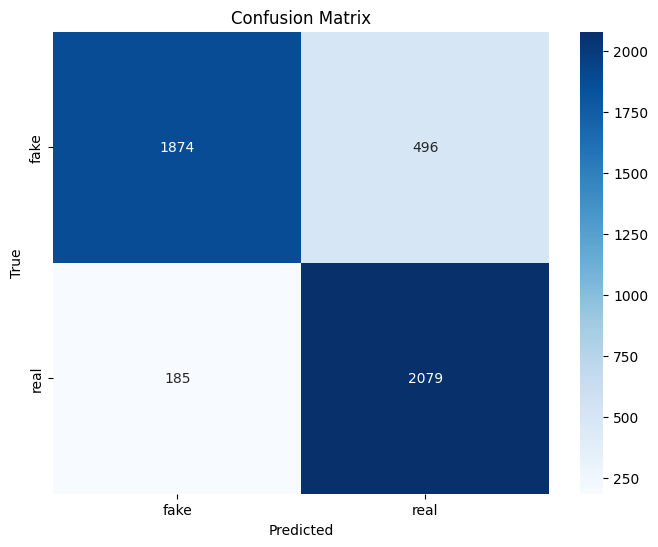

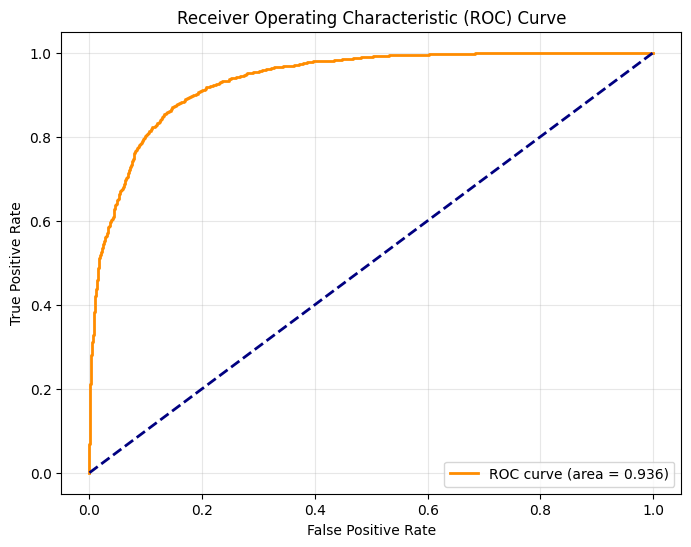

Model saved successfully as .h5
Label encoder saved successfully
Prediction: real, Confidence: 0.9999


In [1]:
# Train and get the model and label encoder
model, label_encoder = deep_ResNet50_classifier()

# Example usage of predict_audio_file
test_audio_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predicted_label, confidence = predict_audio_file(model, test_audio_path, label_encoder)
print(f"Prediction: {predicted_label}, Confidence: {confidence:.4f}")

### VGG16 Model

In [ ]:
# VGG16 model for classification
def deep_VGG16_classifier():  
    # Load data
    X_train, y_train_raw, _ = prepare_features(TRAINING_PATH)
    X_val, y_val_raw, _ = prepare_features(VALIDATION_PATH)
    X_test, y_test_raw, test_paths = prepare_features(TESTING_PATH)

    # Label encoding
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_raw)
    y_train = label_encoder.transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)
    y_test = label_encoder.transform(y_test_raw)

    print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

    # Model input
    input_tensor = Input(shape=(128, 128, 3))

    # Load VGG16 
    base_model = VGG16(weights='/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                       include_top=False, 
                       input_tensor=input_tensor)

    # Freeze the first 70% of layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:int(total_layers * 0.7)]:
        layer.trainable = False
        
    # Model architecture
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    initial_learning_rate = 0.0001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',          
        patience=5,                   
        restore_best_weights=True,   
        verbose=1                    
    )

    # Train model with early stopping and audio augmentation
    history = model.fit(
        audio_data_generator(X_train, y_train, batch_size=16, augment=True),
        steps_per_epoch=len(X_train) // 16,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Print test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {test_accuracy}")
    
    # Classification report
    class_names = [label_encoder.inverse_transform([0])[0], label_encoder.inverse_transform([1])[0]]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Save the model as H5
    model.save("/kaggle/working/deepfake_audio_detector_vgg16.h5")  
    print("Model saved successfully as .h5")

    # Save the label encoder
    joblib.dump(label_encoder, "/kaggle/working/label_encoder.pkl")
    print("Label encoder saved successfully")

    return model, label_encoder


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(


Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav
Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(


Label mapping: {'fake': 0, 'real': 1}
Epoch 1/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 107s 29ms/step - accuracy: 0.6204 - loss: 1.4854 - val_accuracy: 0.5791 - val_loss: 1.2037
Epoch 2/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 93s 26ms/step - accuracy: 0.7662 - loss: 0.9944 - val_accuracy: 0.8900 - val_loss: 0.7002
Epoch 3/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 89s 26ms/step - accuracy: 0.7777 - loss: 0.8116 - val_accuracy: 0.8245 - val_loss: 0.6863
Epoch 4/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 89s 27ms/step - accuracy: 0.8296 - loss: 0.6369 - val_accuracy: 0.9216 - val_loss: 0.3796
Epoch 5/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 90s 27ms/step - accuracy: 0.8394 - loss: 0.5342 - val_accuracy: 0.9263 - val_loss: 0.3241
Epoch 6/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 90s 27ms/step - accuracy: 0.8481 - loss: 0.4670 - val_accuracy: 0.9410 - val_loss: 0.2331
Epoch 7/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 89s 26ms/step - accuracy: 0.8397 - loss: 0.4247 - val_accuracy: 0.8871 - val_loss: 0.3291
Epoch 8/30
3366/3366 ━━━━━━━━━━━━━━━━

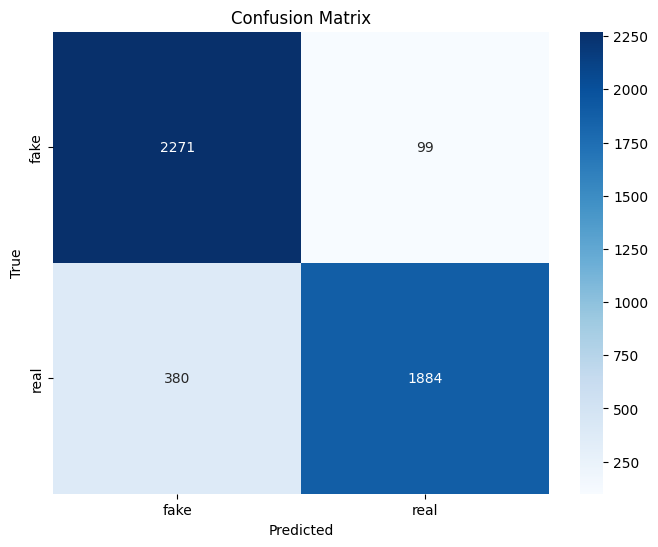

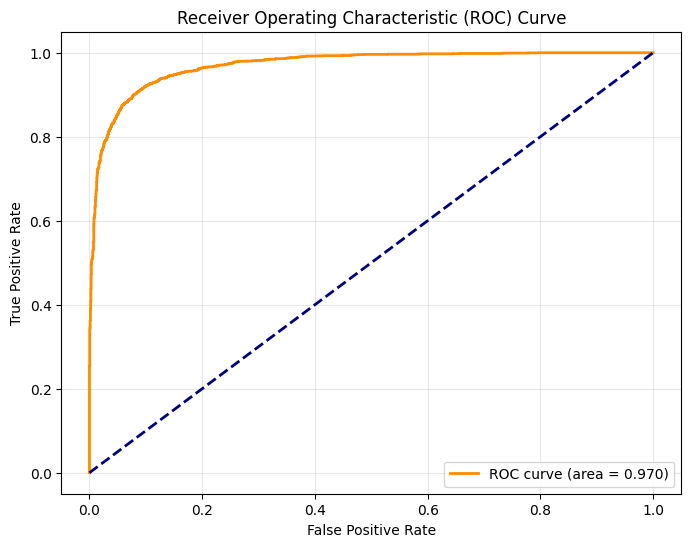

Model saved successfully as .h5
Label encoder saved successfully
Prediction: real, Confidence: 0.9999


In [1]:
# Train and get the model and label encoder
model, label_encoder = deep_VGG16_classifier()  

# Example usage of predict_audio_file
test_audio_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predicted_label, confidence = predict_audio_file(model, test_audio_path, label_encoder)
print(f"Prediction: {predicted_label}, Confidence: {confidence:.4f}")

### MobileNet Model

In [ ]:
# MobileNet model for classification
def deep_MobileNet_classifier():  
    # Load data
    X_train, y_train_raw, _ = prepare_features(TRAINING_PATH)
    X_val, y_val_raw, _ = prepare_features(VALIDATION_PATH)
    X_test, y_test_raw, test_paths = prepare_features(TESTING_PATH)

    # Label encoding
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_raw)
    y_train = label_encoder.transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)
    y_test = label_encoder.transform(y_test_raw)

    print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

    # Model input for MobileNet
    input_tensor = Input(shape=(128, 128, 3))

    # Load MobileNet
    base_model = MobileNet(weights='/kaggle/input/mobilenet-weights/mobilenet_1_0_224_tf_no_top.h5',
                         include_top=False,
                         input_tensor=input_tensor,
                         alpha=1.0)  

    # Freeze the first 70% of layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:int(total_layers * 0.7)]:
        layer.trainable = False
        
    # Model architecture
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    initial_learning_rate = 0.0001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',          
        patience=5,                  
        restore_best_weights=True,   
        verbose=1                 
    )

    # Train model with early stopping and audio augmentation
    history = model.fit(
        audio_data_generator(X_train, y_train, batch_size=16, augment=True),
        steps_per_epoch=len(X_train) // 16,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Print test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {test_accuracy}")
    
    # Classification report
    class_names = [label_encoder.inverse_transform([0])[0], label_encoder.inverse_transform([1])[0]]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Save the model as H5
    model.save("/kaggle/working/deepfake_audio_detector_mobilenet.h5") 
    print("Model saved successfully as .h5")

    # Save the label encoder
    joblib.dump(label_encoder, "/kaggle/working/label_encoder.pkl")
    print("Label encoder saved successfully")

    return model, label_encoder



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(


Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav
Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(


Label mapping: {'fake': 0, 'real': 1}
Epoch 1/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - accuracy: 0.7599 - loss: 1.7096 - val_accuracy: 0.8909 - val_loss: 1.3215
Epoch 2/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.8392 - loss: 1.3850 - val_accuracy: 0.9083 - val_loss: 1.0626
Epoch 3/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.8583 - loss: 1.0989 - val_accuracy: 0.9200 - val_loss: 0.7668
Epoch 4/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.8683 - loss: 0.8002 - val_accuracy: 0.9229 - val_loss: 0.5251
Epoch 5/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.8805 - loss: 0.5736 - val_accuracy: 0.9318 - val_loss: 0.3546
Epoch 6/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.8880 - loss: 0.4357 - val_accuracy: 0.9225 - val_loss: 0.3103
Epoch 7/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.8961 - loss: 0.3535 - val_accuracy: 0.9354 - val_loss: 0.2493
Epoch 8/30
3366/3366 ━━━━━━━━━━━━━━━━━

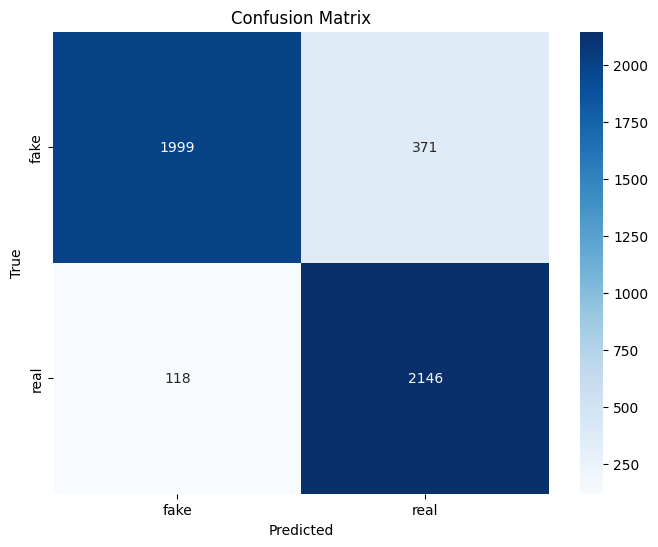

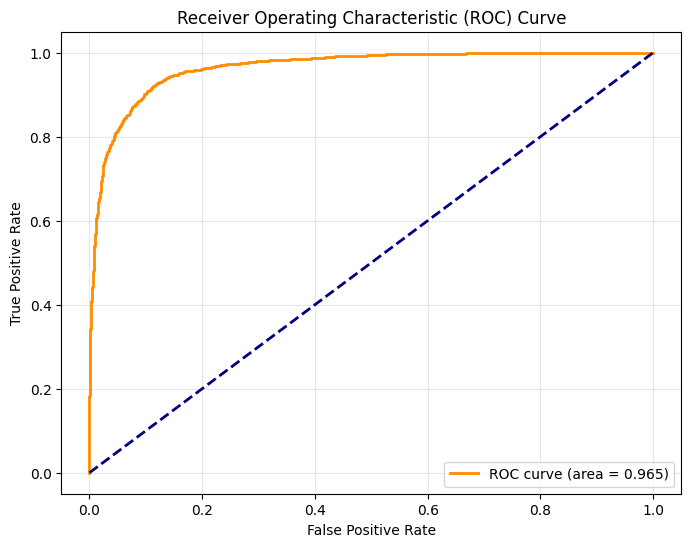

Model saved successfully as .h5
Label encoder saved successfully
Prediction: real, Confidence: 1.0000


In [1]:
# Train and get the model and label encoder
model, label_encoder = deep_MobileNet_classifier()  

# Example usage of predict_audio_file
test_audio_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predicted_label, confidence = predict_audio_file(model, test_audio_path, label_encoder)
print(f"Prediction: {predicted_label}, Confidence: {confidence:.4f}")

### EfficientNetB0 Model

In [ ]:
 # EfficientNetB0 model for classification
def deep_EfficientNetB0_classifier():
    # Load data
    X_train, y_train_raw, _ = prepare_features(TRAINING_PATH)
    X_val, y_val_raw, _ = prepare_features(VALIDATION_PATH)
    X_test, y_test_raw, test_paths = prepare_features(TESTING_PATH)

    # Label encoding
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_raw)
    y_train = label_encoder.transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)
    y_test = label_encoder.transform(y_test_raw)

    print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

    # Model input
    input_tensor = Input(shape=(128, 128, 3))

    # Load EfficientNetB0
    base_model = EfficientNetB0(weights='/kaggle/input/efficientcnn/efficientnetb0_notop.h5',
                                include_top=False, input_tensor=input_tensor)

    # Freeze the first 50% of layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:int(total_layers * 0.5)]:
        layer.trainable = False
        
    # Model architecture
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile model
    initial_learning_rate = 0.0001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',         
        patience=5,                
        restore_best_weights=True,   
        verbose=1                    
    )

    # Train model with early stopping and audio augmentation
    history = model.fit(
        audio_data_generator(X_train, y_train, batch_size=16, augment=True),
        steps_per_epoch=len(X_train) // 16,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Print test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {test_accuracy}")
    
    # Classification report
    class_names = [label_encoder.inverse_transform([0])[0], label_encoder.inverse_transform([1])[0]]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Save the model as H5
    model.save("/kaggle/working/deepfake_audio_detector.h5")
    print("Model saved successfully as .h5")

    # Save the label encoder
    joblib.dump(label_encoder, "/kaggle/working/label_encoder.pkl")
    print("Label encoder saved successfully")

    return model, label_encoder



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(


Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav
Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(


Label mapping: {'fake': 0, 'real': 1}
Epoch 1/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 146s 27ms/step - accuracy: 0.7397 - loss: 1.7669 - val_accuracy: 0.9150 - val_loss: 1.2837
Epoch 2/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 108s 24ms/step - accuracy: 0.8246 - loss: 1.3920 - val_accuracy: 0.9291 - val_loss: 0.9523
Epoch 3/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 80s 24ms/step - accuracy: 0.8487 - loss: 1.0321 - val_accuracy: 0.9368 - val_loss: 0.5986
Epoch 4/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - accuracy: 0.8706 - loss: 0.6886 - val_accuracy: 0.9496 - val_loss: 0.3797
Epoch 5/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - accuracy: 0.8872 - loss: 0.4797 - val_accuracy: 0.9596 - val_loss: 0.2549
Epoch 6/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 80s 24ms/step - accuracy: 0.9007 - loss: 0.3683 - val_accuracy: 0.9626 - val_loss: 0.1801
Epoch 7/30
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.9142 - loss: 0.2978 - val_accuracy: 0.9712 - val_loss: 0.1429
Epoch 8/30
3366/3366 ━━━━━━━━━━━━━━━

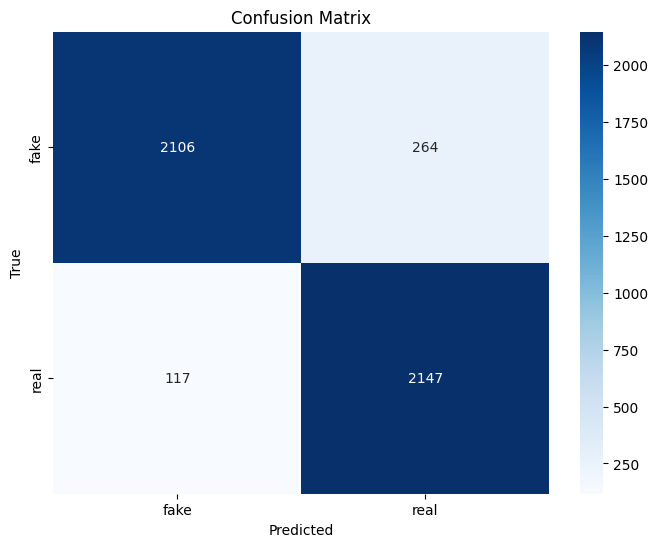

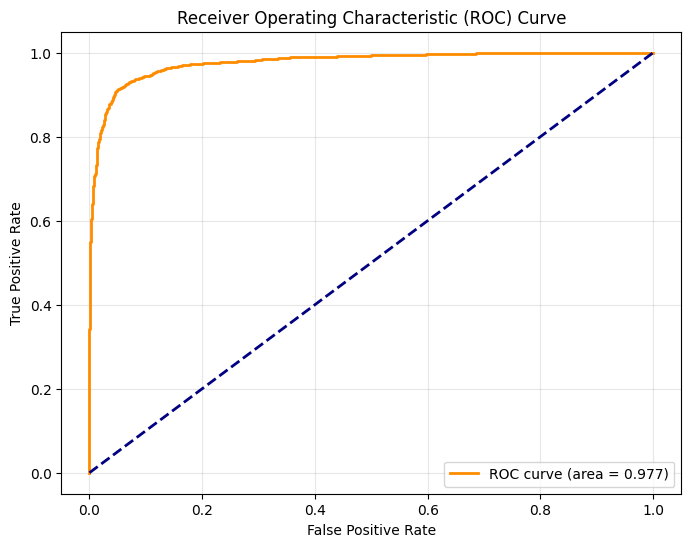

Model saved successfully as .h5
Label encoder saved successfully
Prediction: real, Confidence: 1.0000


In [1]:
# Train and get the model and label encoder
model, label_encoder = deep_EfficientNetB0_classifier()

# Example usage of predict_audio_file
test_audio_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predicted_label, confidence = predict_audio_file(model, test_audio_path, label_encoder)
print(f"Prediction: {predicted_label}, Confidence: {confidence:.4f}")

### Custom CNN

Different normalization technique used in the feature exteraction function for CNN model 

In [ ]:
# Extract MFCC and additional features with noise handling
def extract_features(file_path, sr=16000, n_mfcc=40, duration=12):
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr * 0.1:
            print(f"Skipping short file: {file_path}")
            return None
        
        # Simple noise reduction
        # Assuming first 100ms is silence/noise, estimate noise profile
        noise_sample = y[:int(sr * 0.1)]
        if len(noise_sample) > 0:
            noise_mean = np.mean(noise_sample)
            noise_std = np.std(noise_sample)
            # Set a threshold for noise removal (3 standard deviations)
            threshold = noise_mean + 3 * noise_std
            # Apply soft noise gate
            y = np.where(np.abs(y) < threshold, y * 0.1, y)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < 3:
            print(f"Insufficient frames for delta computation in file: {file_path}")
            return None
        
        # Resize MFCC for CNN input 
        mfcc_resized = librosa.util.fix_length(mfcc, size=224, axis=1)
        if mfcc_resized.shape[1] < 224:
            padding = 224 - mfcc_resized.shape[1]
            mfcc_resized = np.pad(mfcc_resized, ((0, 0), (0, padding)), mode='constant')
        mfcc_img = np.resize(mfcc_resized, (128, 128))
        
        # Create a 3-channel image for CNN input
        # Instead of using preprocess_input, we'll normalize manually
        mfcc_img_3ch = np.stack((mfcc_img, mfcc_img, mfcc_img), axis=-1)
        
        # Normalize to [-1, 1] range
        mfcc_img_3ch = (mfcc_img_3ch - np.mean(mfcc_img_3ch)) / (np.std(mfcc_img_3ch) + 1e-7)
        
        return mfcc_img_3ch
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Audio augmentation function
def add_white_noise(audio, noise_level=0.005):
    """Add white noise to audio signal"""
    noise = np.random.normal(0, noise_level, len(audio))
    return audio + noise

def time_stretch(audio, rate=1.0):
    """Time stretch audio signal without changing pitch"""
    if rate == 1.0:  
        return audio
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sr, n_steps=0):
    """Shift pitch of audio signal"""
    if n_steps == 0: 
        return audio
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def apply_audio_augmentation(y, sr=16000):
    """Apply random audio augmentations"""
    augmented = y.copy()
    
    # Randomly select and apply augmentations
    # 1. Add white noise (50% chance)
    if np.random.random() > 0.5:
        noise_level = np.random.uniform(0.001, 0.01)
        augmented = add_white_noise(augmented, noise_level)
    
    # 2. Time stretch (50% chance)
    if np.random.random() > 0.5:
        stretch_rate = np.random.uniform(0.8, 1.2)
        augmented = time_stretch(augmented, stretch_rate)
    
    # 3. Pitch shift (50% chance)
    if np.random.random() > 0.5:
        n_steps = np.random.randint(-4, 5)
        augmented = pitch_shift(augmented, sr, n_steps)
    
    return augmented

# Function to test model prediction on a single audio file
def predict_audio_file(model, audio_file_path, label_encoder, sr=16000, n_mfcc=40, duration=12):
    try:
        # Extract features using the same preprocessing as training
        features = extract_features(audio_file_path, sr=sr, n_mfcc=n_mfcc, duration=duration)
        if features is None:
            return "Error: Could not extract features from the audio file", 0.0
        # Reshape features for model input
        features = np.expand_dims(features, axis=0)  
        
        # Get prediction
        prediction = model.predict(features, verbose=0)
        confidence = float(prediction[0][0])
        
        # Convert to binary prediction
        predicted_class = 1 if confidence > 0.5 else 0
        predicted_label = label_encoder.inverse_transform([predicted_class])[0]
        
        # Calculate confidence score (matching deployment logic)
        confidence_score = confidence if predicted_class == 1 else 1.0 - confidence
        
        return predicted_label, confidence_score
        
    except Exception as e:
        return f"Error processing {audio_file_path}: {str(e)}", 0.0

# Prepare features with online augmentation
def prepare_features(data_path, augment_data=False):
    data = load_audio_files(data_path)
    
    # Process all files
    features_list = []
    valid_indices = []
    
    for idx, file_path in enumerate(data['file_path']):
        features = extract_features(file_path)
        if features is not None:
            features_list.append(features)
            valid_indices.append(idx)
    
    # Filter only valid samples
    valid_data = data.iloc[valid_indices].reset_index(drop=True)
    
    X = np.array(features_list)
    y_raw = valid_data['label'].values
    return X, y_raw, valid_data['file_path'].values

# Function to create augmented features on-the-fly during training
def augment_mfcc_features(batch_x, batch_y):
    """Apply augmentations directly to MFCC feature representations"""
    augmented_x = batch_x.copy()
    
    for i in range(len(augmented_x)):
        # Random frequency masking (50% chance)
        if np.random.random() > 0.5:
            freq_idx = np.random.randint(0, augmented_x.shape[1] - 10)
            freq_width = np.random.randint(5, 15)
            augmented_x[i, freq_idx:freq_idx+freq_width, :, :] *= np.random.uniform(0.0, 0.6)
        
        # Random time masking (50% chance)
        if np.random.random() > 0.5:
            time_idx = np.random.randint(0, augmented_x.shape[2] - 20)
            time_width = np.random.randint(5, 20)
            augmented_x[i, :, time_idx:time_idx+time_width, :] *= np.random.uniform(0.0, 0.6)
        
        # Random gain adjustment (50% chance)
        if np.random.random() > 0.5:
            gain_factor = np.random.uniform(0.7, 1.3)
            augmented_x[i] = augmented_x[i] * gain_factor
            # Clip to maintain valid range
            augmented_x[i] = np.clip(augmented_x[i], -1.0, 1.0)
    
    return augmented_x, batch_y

# Custom audio data generator
def audio_data_generator(X, y, batch_size=16, augment=True):
    num_samples = len(X)
    indices = np.arange(num_samples)
    
    while True:
        np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]
            
            if augment:
                batch_X, batch_y = augment_mfcc_features(batch_X, batch_y)
            
            yield batch_X, batch_y



In [ ]:
# Custom CNN model for classification
def create_custom_cnn_model(input_shape=(128, 128, 3)):
    """
    Create a custom CNN model for audio deepfake detection
    """
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    # Fourth convolutional block
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    # Global pooling and fully connected layers
    model.add(GlobalAveragePooling2D())
    
    # Dense layers
    model.add(Dense(512, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Custom CNN classifier function
def deep_custom_CNN_classifier():
    # Load data
    X_train, y_train_raw, _ = prepare_features(TRAINING_PATH)
    X_val, y_val_raw, _ = prepare_features(VALIDATION_PATH)
    X_test, y_test_raw, test_paths = prepare_features(TESTING_PATH)

    # Label encoding
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_raw)
    y_train = label_encoder.transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)
    y_test = label_encoder.transform(y_test_raw)

    print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

    # Create custom CNN model
    model = create_custom_cnn_model(input_shape=(128, 128, 3))

    # Compile model
    initial_learning_rate = 0.0001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',         
        patience=5,                 
        restore_best_weights=True,  
        verbose=1                   
    )

    # Print model summary
    model.summary()

    # Train model with early stopping and audio augmentation
    history = model.fit(
        audio_data_generator(X_train, y_train, batch_size=16, augment=True),
        steps_per_epoch=len(X_train) // 16,
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate model
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Print test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {test_accuracy}")
    
    # Classification report
    class_names = [label_encoder.inverse_transform([0])[0], label_encoder.inverse_transform([1])[0]]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Save the model as H5
    model.save("/kaggle/working/deepfake_audio_detector_custom_cnn.h5")
    print("Model saved successfully as .h5")

    # Save the label encoder
    joblib.dump(label_encoder, "/kaggle/working/label_encoder.pkl")
    print("Label encoder saved successfully")

    return model, label_encoder



/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(


Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav
Skipping short file: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(


Label mapping: {'fake': 0, 'real': 1}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,0

 Total params: 1,305,729 (4.98 MB)

 Trainable params: 1,302,657 (4.97 MB)

 Non-trainable params: 3,072 (12.00 KB)

Epoch 1/20
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 196s 54ms/step - accuracy: 0.8304 - loss: 1.0106 - val_accuracy: 0.8884 - val_loss: 0.7367
Epoch 2/20
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 176s 50ms/step - accuracy: 0.8704 - loss: 0.7063 - val_accuracy: 0.9047 - val_loss: 0.5127
Epoch 3/20
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 169s 50ms/step - accuracy: 0.8908 - loss: 0.5099 - val_accuracy: 0.9091 - val_loss: 0.4055
Epoch 4/20
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 169s 50ms/step - accuracy: 0.9051 - loss: 0.3907 - val_accuracy: 0.7837 - val_loss: 0.5825
Epoch 5/20
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 169s 50ms/step - accuracy: 0.9099 - loss: 0.3230 - val_accuracy: 0.5173 - val_loss: 2.4328
Epoch 6/20
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 169s 50ms/step - accuracy: 0.9203 - loss: 0.2747 - val_accuracy: 0.9218 - val_loss: 0.2451
Epoch 7/20
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 170s 51ms/step - accuracy: 0.9273 - loss: 0.2436 - val_accuracy: 0.9201 - val_loss: 0.2410
Epoch 8/20
3366/3366 ━━━━━━━━━━━━━━━━━━━━ 169s 50ms/step - accuracy: 

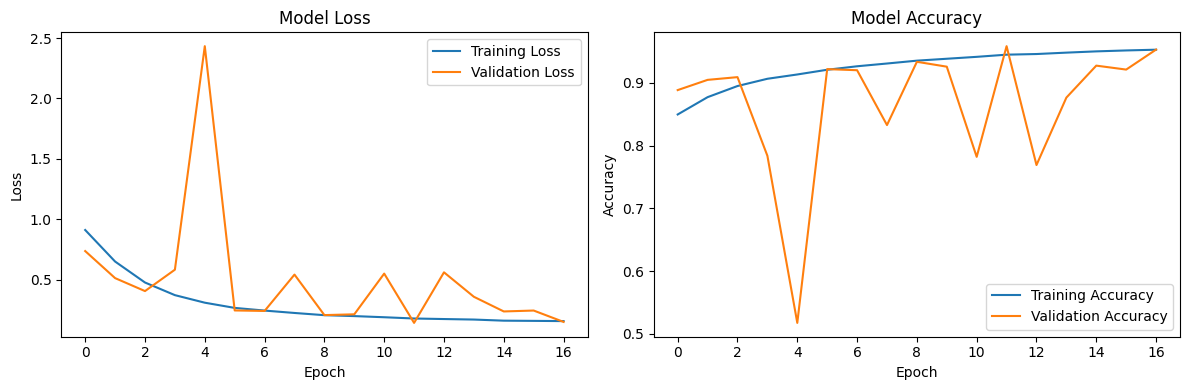

145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step

Test Accuracy: 0.8411739318083729

Classification Report:
              precision    recall  f1-score   support

        fake       0.78      0.95      0.86      2370
        real       0.94      0.72      0.82      2264

    accuracy                           0.84      4634
   macro avg       0.86      0.84      0.84      4634
weighted avg       0.86      0.84      0.84      4634



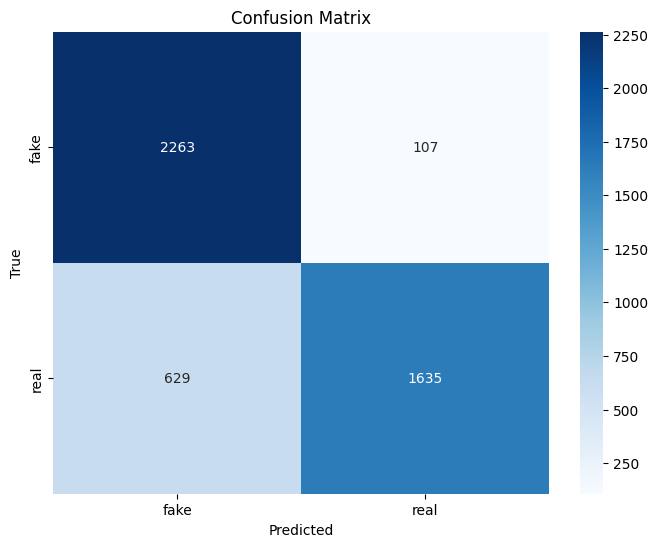

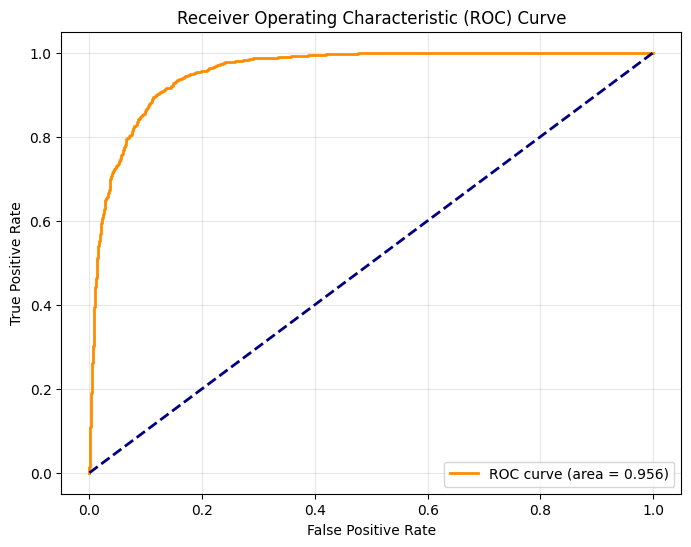

Model saved successfully as .h5
Label encoder saved successfully
Prediction: real, Confidence: 0.9358


In [1]:
# Train and get the model and label encoder
model, label_encoder = deep_custom_CNN_classifier()

# Example usage of predict_audio_file
test_audio_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/testing/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
predicted_label, confidence = predict_audio_file(model, test_audio_path, label_encoder)
print(f"Prediction: {predicted_label}, Confidence: {confidence:.4f}")